In [147]:
""" 
 !pip install log4py
 !pip install dill
 !pip install jupyter_contrib_nbextensions
 !pip install ruamel.yaml
 !pip install seaborn
 !pip install scipy
 !pip install scikit-learn
 !pip install pyDOE
 !pip install rpy2
 !pip install GPy
 !pip install --upgrade numpy
 !pip install --upgrade GPy
 !pip install optimparallel
 """

' \n !pip install log4py\n !pip install dill\n !pip install jupyter_contrib_nbextensions\n !pip install ruamel.yaml\n !pip install seaborn\n !pip install scipy\n !pip install scikit-learn\n !pip install pyDOE\n !pip install rpy2\n !pip install GPy\n !pip install --upgrade numpy\n !pip install --upgrade GPy\n !pip install optimparallel\n '

In [148]:
# Import necessary packages
import os
import yaml
import logging
import argparse
from pathlib import Path
from ruamel.yaml import YAML
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from log4py import Logger
import importlib.util
import random
import dill as pickle
import pickle
from scipy import stats
import seaborn as sns

# This is needed otherwise the jupyter notebook will have trouble with memory 
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning, module='sklearn')


In [149]:
# Setting directory paths 
shared_env = {}

# Server paths
dir_path = "/home/s212597/BOcalibration/Tallinn_Python"
DEFAULT_CONFIG_FILENAME = os.path.join(dir_path, "config", "defaults.yml")
DEFAULT_LOGGING_FILENAME = os.path.join(dir_path, "config", "logger.yml")
CONFIG_FILE= os.path.join(dir_path, "config","preday","config_server_tallinn_tripsmode_qn.yml")

UPDATE_DEF = False

# Main Body


## Configuration Functions

In [150]:
def load_library(library, library_path):
    """
    Load a specified library if it is properly set up.
    
    :param library: Name of the library.
    :param library_path: Path to the library on disk.
    
    :return: A dictionary containing a status code and optionally a message or data. 
             If the library is loaded successfully, the data key contains the library data.
    """
    if not os.path.exists(os.path.join(library_path, "__init__.ipynb")):
        return {"code": 1, "message": f"The library {library} was not properly set up. No __init__.ipynb file found. Thus, it is not loaded."}
    
    with open(os.path.join(library_path, "config", "defaults.yml")) as f:
        yaml = YAML(typ="safe")
        defaults = yaml.load(f)
    
    return {"data": reduce(lambda d, k: d.get(k, {}), library_path.split(os.path.sep), {}), "code": 0} if defaults else {"code": 1, "message": f"The library {library} is initialized without default settings."}

In [151]:
def load_logger(config_path, run_id, level="INFO"):
    """
    Initialize a logger based on a given configuration path and run ID.

    :param config_path: Path to the configuration file containing logger settings.
    :param run_id: Unique identifier for the current run, used to create a unique logfile name.
    :param level: Logging level, e.g., INFO, DEBUG, ERROR, etc. Defaults to INFO.

    :return: A configuration dictionary loaded from the configuration file.
    """
    yaml = YAML(typ="safe")
    with open(config_path) as f:
        config = yaml.load(f)
        
    if not os.path.exists(config["LOG_PATH"]):
        os.makedirs(config["LOG_PATH"], exist_ok=True)
        
    logfile = os.path.join(config["LOG_PATH"], f"log_{run_id}.txt")
    logger = Logger(logfile)  #logfile, level=level)                         
    
    return config

## Configurations

In [152]:
# Initialize an argument parser.
parser = argparse.ArgumentParser()
parser.add_argument('-f', '--fingerprint', type=str, default=None, help='Run fingerprint')
parser.add_argument('-m', '--surrogate_model', type=str, default=None, help='Surrogate model')
parser.add_argument('-u', '--uitility_function', type=str, default=None, help='Utility function')
parser.add_argument('-s', '--param_change_share', type=float, default=None, help='Share of parameters to be changed at each iteration')
parser.add_argument('-v', '--param_change_variation', type=float, default=None, help='Variation of parameter change at each iteration')
parser.add_argument('-C', '--config_file', type=str, default='config/preday/config_local.yml', help='Config file to load')
parser.add_argument('-P', '--param_definition_file', type=str, default=None, help='Parameters file to load')
parser.add_argument('-E', '--param_exclusion_file', type=str, default=None, help='File with exluded parameters to load')
parser.add_argument('-A', '--city_actual_stats', type=str, default=None, help='File with true city statistics')
parser.add_argument('-O', '--object_storage_path', type=str, default=None, help='Path where output objects will be stored')
parser.add_argument('-X', '--sh_scripts_path', type=str, default=None, help='Path of shell scripts for executing commands over the simulator')
parser.add_argument('-H', '--container_home', type=str, default=None, help='Home path of container runtime and configuration')
parser.add_argument('-c', '--containerized', type=bool, default=None, help='Flag for executing simulation in container (Docker)')
parser.add_argument('-i', '--container_image', type=str, default=None, help='Container image name')
parser.add_argument('-b', '--initialization_only', type=bool, default=False, help='Indicator to indicate only initialization of random seed and initial sample set')
args, unknown = parser.parse_known_args()

In [153]:
# Setup running and configuration fingerprint settings
settings = {}
settings["SCOPE"] = "preday"
settings["FINGERPRINT"] = round(time.time() * 1000)

# Load logger
yaml = YAML(typ="safe")
with open(DEFAULT_LOGGING_FILENAME) as f:
    log_config = yaml.load(f)
    
#logger = load_logger(DEFAULT_LOGGING_FILENAME,settings["FINGERPRINT"], level="INFO")
settings["logger"] = log_config

# Load default configuration
with open(DEFAULT_CONFIG_FILENAME) as f:
    default_config = yaml.load(f)
    
settings["DEFAULTS"] = default_config
settings = {**settings["DEFAULTS"], **settings}
del settings["DEFAULTS"]


In [154]:
# Load preloaded libraries
if "PRELOADED_LIBRARIES" in settings and settings["PRELOADED_LIBRARIES"] is not None:
    for lib_name in settings["PRELOADED_LIBRARIES"]:
        lib_path = os.path.join(settings["LIB_PATH"], lib_name)
        lib_config = load_library(lib_name, lib_path)
        
        if "data" in lib_config:
            settings.update(lib_config["data"])
        else:
            if lib_config["code"] == 1 and "message" in lib_config:
                logger.warn(lib_config["message"])
            elif lib_config["code"] == 2 and "message" in lib_config:
                logger.error(lib_config["message"])
                
with open(CONFIG_FILE) as f:
    provided_config = yaml.load(f)

settings["PROVIDED_CONFIGURATION"] = provided_config
settings = {**settings["PROVIDED_CONFIGURATION"], **settings}
del settings["PROVIDED_CONFIGURATION"]


# Load additional libraries (if specified)
if "LIBRARIES" in provided_config and len(provided_config["LIBRARIES"]) > 0:
    for library in provided_config["LIBRARIES"]:
        if library == "preday":
            lib_config = load_library(library, os.path.join(dir_path, "libs", library)) 

            if "data" in lib_config:
                settings.update(lib_config["data"])
            elif lib_config["code"] == 1 and "message" in lib_config and lib_config["message"] is not None:
                logger.warn(lib_config["message"])
            elif lib_config["code"] == 2 and "message" in lib_config and lib_config["message"] is not None:
                logger.error(lib_config["message"])

### Creating file paths


In [155]:
if args.surrogate_model is not None:
    settings['SURROGATE_MODEL_STR'] = args.surrogate_model
if args.uitility_function is not None:
    settings['UTILITY_FUNC_STR'] = args.uitility_function
if args.object_storage_path is not None:
    settings['OBJECT_STORAGE_PATH'] = args.object_storage_path
if args.param_definition_file is not None:
    settings['INITIAL_PARAMS_PATH'] = args.param_definition_file
if args.param_exclusion_file is not None:
    settings['OMITTED_PARAMS_PATH'] = args.param_exclusion_file
if args.city_actual_stats is not None:
    settings['OBSERVED_STATS_PATH'] = args.city_actual_stats
if args.container_home is not None:
    settings['CONTAINER_HOME_PATH'] = args.container_home
if args.sh_scripts_path is not None:
    settings['SH_SCRIPTS'] = args.sh_scripts_path
if args.param_change_share is not None:
    settings['CHANGE_SHARE_ATTRIBUTES'] = args.param_change_share
if args.param_change_variation is not None:
    settings['VARIATION_SD'] = args.param_change_variation
if args.containerized is not None:
    settings['CONTAINERIZED'] = args.containerized
if args.container_image is not None:
    settings['IMAGE_NAME'] = args.container_image
if args.initialization_only is not None:
    settings['INIT_ONLY'] = args.initialization_only

# Testing mode
settings["MOCKING_MODE"]=False

# Creating file paths

settings["SH_SCRIPTS"]= os.path.join(dir_path,"containers_preday_sing_triton","scripts_sh")
settings['OBSERVED_STATS_PATH'] = os.path.join(dir_path,"data_preday","tallin_od_weighted_coded.csv")
settings['DISTRICT_MAP_PATH'] = os.path.join(dir_path,"data_preday","tallinn_grid_def.csv")
settings['WEIGHT_MAP_PATH'] = os.path.join(dir_path,"data_preday","tallinn_od_mask_coded.csv")
settings['MODE_BALANCE_PATH'] = os.path.join(dir_path,"data_preday","tallinn_mode_balance.csv")
settings['WORKERS_POPULATION_PATH'] = os.path.join(dir_path,"data_preday","tallinn_population_workers.csv")
settings['INITIAL_PARAMS_PATH'] = os.path.join(dir_path,"data_preday","preday_params_complete_tours_modes_v3.csv")

# Danish datasets paths
# WILL BE CHANGED
settings['time_distribution'] = os.path.join(dir_path,"time_distribution.csv")
settings['trips_distribution'] = os.path.join(dir_path,"trips_distribution.csv")

# Creating script paths 
settings["PARAM_FILE_PATH"] = os.path.join(dir_path,"scripts", "behavior_vc_archive_1")          
settings["PARAM_FILE_EXTENSION"] = os.path.join(settings["PARAM_FILE_PATH"],"dpb.lua")           

settings["CONTAINER_RUNTIME_PATH"] = os.path.join(settings["CONTAINER_HOME_PATH"], "runtime")
settings["OBJECT_PATH"] = os.path.abspath(os.path.join(".", settings["OBJECT_STORAGE_PATH"], f"output_{settings['FINGERPRINT']}"))
settings["RANDOM_SEED_FILE"] = os.path.join(settings["OBJECT_PATH"], f"bolfi_{settings['SCOPE']}_random_seed_object.Rds")
settings["PARAM_SPACE_FILE"] = os.path.join(settings["OBJECT_PATH"], f"bolfi_{settings['SCOPE']}_param_space_object.Rds")
settings["OUTPUT_FILE"] = os.path.join(settings["OBJECT_PATH"], f"bolfi_{settings['SCOPE']}_output_object.Rds")
settings["CONFIGURATION_OUTPUT_FILE"] = os.path.join(settings["OBJECT_PATH"], f"bolfi_{settings['SCOPE']}_configuration_object.Rds")

# Adapt the local file system and necessary file loadings
if not os.path.exists(settings["OBJECT_PATH"]):
    os.makedirs(settings["OBJECT_PATH"])
if not os.path.exists(settings["CONTAINER_RUNTIME_PATH"]):
    os.makedirs(settings["CONTAINER_RUNTIME_PATH"])

## Load the observation files and parameters

In [156]:

# Creating the paths to load city stats (individuals_10)
settings['CITY_STATS'] = {}
settings['CITY_STATS']['value'] = pd.read_csv(settings['OBSERVED_STATS_PATH'], index_col=0, encoding="UTF-8").values * (settings['PARTIAL_POPULATION'] if 'PARTIAL_POPULATION' in settings else 1)
settings['CITY_STATS']['total_trips'] = np.sum(settings['CITY_STATS']['value'], axis=None, keepdims=False)

# Danish Travel Survey data
settings['CITY_STATS']["trips_distribution"] = pd.read_csv(settings['trips_distribution'], encoding="UTF-8")
settings['CITY_STATS']["time_distribution"]= pd.read_csv(settings['time_distribution'], encoding="UTF-8")

# Talin datasets (for future Danish related datasets)
if 'RELATIVE_OD' in settings and settings['RELATIVE_OD']:
    settings['CITY_STATS']['value'] = settings['CITY_STATS']['value'] / np.sum(settings['CITY_STATS']['value'])
settings['CITY_STATS']['district_map'] = pd.read_csv(settings['DISTRICT_MAP_PATH'], encoding="UTF-8")
if 'WEIGHT_MAP_PATH' in settings:
    settings['CITY_STATS']['weights'] = pd.read_csv(settings['WEIGHT_MAP_PATH'], index_col=0, encoding="UTF-8").values
if 'MODE_BALANCE_PATH' in settings:
    settings['CITY_STATS']['balance'] = pd.read_csv(settings['MODE_BALANCE_PATH'], encoding="UTF-8")
if 'WORKERS_POPULATION_PATH' in settings:
    settings['CITY_STATS']['workers'] = pd.read_csv(settings['WORKERS_POPULATION_PATH'], encoding="UTF-8")

OD_cells = np.arange(len(settings['CITY_STATS']['value']))
settings['CITY_STATS']['emptyOD'] = np.zeros((len(OD_cells), len(OD_cells)))
settings['CITY_STATS']['emptyOD'] = pd.DataFrame(settings['CITY_STATS']['emptyOD'], index=OD_cells, columns=OD_cells)

# If omit file provided, load it
settings["OMIT_LIST"] = []
if "OMITTED_PARAMS_PATH" in settings and not pd.isna(settings["OMITTED_PARAMS_PATH"]):
    omit_df = pd.read_csv(settings["OMITTED_PARAMS_PATH"])
    settings["OMIT_LIST"] = omit_df["parameter"].tolist()

# If external method is used, adapt the directories for input and output to be the same as the current run home directory
if "EXTERNAL_METHOD" in settings:                                                                 # external 
    settings["METHOD_INPUT_PATH"] = os.path.join(os.path.abspath(settings["OBJECT_PATH"]), "")
    settings["METHOD_OUTPUT_PATH"] = os.path.join(os.path.abspath(settings["OBJECT_PATH"]), "")

    settings["CONTAINER_HOME_PATH"] = os.path.abspath(settings["CONTAINER_HOME_PATH"])
    settings["CONTAINER_RUNTIME_PATH"] = os.path.abspath(settings["CONTAINER_RUNTIME_PATH"])

    if "EXTERNAL_FEEDBACK_SCRIPT" in settings:
        shutil.copy(settings["EXTERNAL_FEEDBACK_SCRIPT"], settings["OBJECT_PATH"])


In [157]:
# If READ_MEMORY setting is enabled, and a file for parameter space object exists in the defined path 
# but not in the location defined by 'PARAM_SPACE_FILE', then copy the file to 'PARAM_SPACE_FILE'.
if (settings['READ_MEMORY'] and os.path.exists(f"./{settings['OBJECT_STORAGE_PATH']}/bolfi_{settings['SCOPE']}_param_space_object.Rds") and 
    not os.path.exists(settings['PARAM_SPACE_FILE'])):
    
    shutil.copy(f"./{settings['OBJECT_STORAGE_PATH']}/bolfi_{settings['SCOPE']}_param_space_object.Rds", settings['PARAM_SPACE_FILE'])

# If READ_MEMORY setting is enabled, and a file for random seed object exists in the defined path 
# but not in the location defined by 'RANDOM_SEED_FILE', then copy the file to 'RANDOM_SEED_FILE'.
if (settings['READ_MEMORY'] and os.path.exists(f"./{settings['OBJECT_STORAGE_PATH']}/bolfi_{settings['SCOPE']}_random_seed_object.Rds") and 
    not os.path.exists(settings['RANDOM_SEED_FILE'])):
    
    shutil.copy(f"./{settings['OBJECT_STORAGE_PATH']}/bolfi_{settings['SCOPE']}_random_seed_object.Rds", settings['RANDOM_SEED_FILE'])
       
 # Set function names for surrogate modeling, prediction, and utility based on the selected surrogate model and utility function strings.   
settings['SURROGATE_MODEL_FN'] = f"fn_fit_{settings['SURROGATE_MODEL_STR']}"
settings['SURROGATE_PREDICT_FN'] = f"fn_predict_{settings['SURROGATE_MODEL_STR']}"
settings['SURROGATE_UTILITY_FN'] = f"fn_utility_{settings['UTILITY_FUNC_STR']}"
settings['HEADER'] = list(settings.keys())

In [158]:

# Function for verbose_output
def verbose_output(msg, **kwargs):
    """
    Logs a message along with provided parameters in a structured format.

    :param msg: The main message to log.
    :param kwargs: Additional parameters to be included in the log message.
    """
    message_params_str = ', '.join([f"{key}: {value}" for key, value in kwargs.items()])
    logger.info(f"{msg} |=> {message_params_str}")

def save_object(obj,settings, filename="space",  **kwargs):
    """
    Serialize and save an object to a pickle file.

    :param obj: The object to be saved.
    :param settings: Configuration or settings data (currently not used in the function body but might be used for future enhancements).
    :param filename: The base name of the file to which the object should be saved (defaults to "space").
    :param kwargs: Additional parameters, not used currently but can be used for future enhancements.
    """
    with open('iteration.pkl', 'wb') as f:
        pickle.dump(obj, f)



## Preday functions

In [159]:
# Preday imports
import pandas as pd
import re
from typing import List, Union
from pyDOE import lhs
import subprocess
import os

In [160]:
def fn_load_params_space_definition(filepath: str, omit: Union[List[str], str] = list(), sys_modules: List[str] = ["preday"], 
                                    tunnel_constraint: bool = True, update_initial: bool = False):
    """
    Load parameter space definitions from a CSV file and process them.

    :param filepath: Path to the CSV file containing parameter space definitions.
    :param omit: Columns or parameters to omit from the output.
    :param sys_modules: List of system modules to consider.
    :param tunnel_constraint: Boolean flag indicating whether tunnel constraints should be applied.
    :param update_initial: Boolean flag to control updating the initial values. Not used in current implementation.
    :return: A dictionary with the processed parameter space definitions.
    """

    # Predefined lists for categorizing models
    no_tours_models = ["dpb", "dps", "dpt", "nte", "ntw", "nto", "nts", "isg", "imd", "tuw"]
    mode_balance_models = ["tme", "tmw", "stmd", "tmdo", "tmds", "tmdw", "wdme", "wdmso", "wdmw"]
    low_priority_models = ["tws", "sttd", "ttde", "ttdw", "ttdo", "itd", "ptrc", "pvtrc", "zpa"]

    # Read the CSV file
    file_content = pd.read_csv(filepath)
    
    # Filter the data based on provided modules and inclusion flag
    file_content = file_content[(file_content['module'].isin(sys_modules)) & (file_content['include'])]

    # Split the 'param' column into separate 'param_name' and 'value' columns based on '=' delimiter
    file_content[['param_name', 'value']] = file_content['param'].str.extract(r'^(.+?)\s*=\s*(.+)$')

    # Further process and extract relevant information from the 'param' column
    file_content['declaration'] = file_content['param'].str.extract(r'^(.+?)(?=beta|cons)')
    file_content['param_name_left_hand'] = file_content['param_name']
    file_content['param_name'] = file_content['param_name'].str.replace(r'(local |bundled_variables\.)', '', regex=True).str.strip()
    file_content['parameter'] = file_content['model'] + '_' + file_content['param_name']
    file_content['raw_value'] = file_content['value'].str.strip()
    file_content['value'] = pd.to_numeric(file_content['value'].str.replace(r'\s', '', regex=True))

    # Classify models into direct influence categories
    file_content['direct_influence'] = file_content['model'].apply(lambda x: 'tours' if x in no_tours_models else ('mode' if x in mode_balance_models else 'none'))

    # Setup lower and upper limit columns if not present
    if 'lower_limit' not in file_content.columns:
        file_content['lower_limit'] = 0
    if 'upper_limit' not in file_content.columns:
        file_content['upper_limit'] = np.inf
    file_content['enabled'] = file_content['lower_limit'] != file_content['upper_limit']

    # Handle omit parameter
    if not isinstance(omit, list) and len(omit) == 1:
        omit_col_name = omit
        omit = file_content.loc[file_content[omit_col_name], 'parameter'].tolist()
        file_content = file_content.drop(columns=[omit_col_name])
    file_content = file_content[~file_content['parameter'].isin(omit)]

    # Prepare column headers
    column_header = file_content['parameter'].tolist()
    residual_pool_header = ["time", "trips", "od"]

    # Apply tunnel constraints if specified
    if tunnel_constraint:
        t_width = 2.0
        t_restricted_width = 0.05
        # Set lower and upper limit values based on initial values and constraints
        file_content['lower_limit'] = file_content.apply(lambda row: row['initial'] if not row['enabled'] else (row['initial'] - t_restricted_width if re.search(r"logsum", row['parameter']) else row['initial'] - t_width), axis=1)
        file_content['upper_limit'] = file_content.apply(lambda row: row['initial'] if not row['enabled'] else (row['initial'] + t_restricted_width if re.search(r"logsum", row['parameter']) else row['initial'] + t_width), axis=1)
        file_content['tunnel_width'] = t_width

    # Create final definition and space dataframes
    definition = file_content.drop(columns=['value', 'raw_value']).assign(
        changed=file_content['parameter'].apply(lambda x: x not in omit),
        init_lower_limit=file_content['lower_limit'],
        init_upper_limit=file_content['upper_limit']
    )
    space = file_content[['value']].T.set_axis(column_header, axis=1).head(0)
    value_pool = {column: [] for column in column_header}
    residual_pool = {column: [] for column in residual_pool_header}

    return {
        'definition': definition,
        'space': space,
        'value_pool': value_pool,
        'residual_pool': residual_pool
    }

In [161]:
def fn_preday_sampling(param_space,sample_size,vals=None, **kwargs):

    """
    Function to generate sampling of preday parameter space.

    Args:
        param_space (dict): Dictionary containing parameter space definitions.
        sample_size (int): Size of the sample to generate.
        vals (array, optional): Previously generated values.
        **kwargs: Keyword arguments for specific sampling methods and options.

    Returns:
        numpy.array: Generated sample.
    """

    print("fn_preday_sampling")
           
    # check if the given vals and param_space arguments are None or empty
        
    is_initial = True if (vals is None or param_space['space'].shape[0] == 0) else False
    
    # get the indexes of enabled parameters
    enabled_idx = np.arange(param_space['definition'].shape[0])
    if 'enabled' in param_space['definition'].columns:                            #.dtype.names:
        enabled_idx = np.where(param_space['definition']['enabled'] == True)[0]
    
    # get the names of enabled parameters
    dim_names = param_space['definition']['parameter']

    # get the number of enabled parameters
    sample_dim = len(enabled_idx)
    
    # create the generated sample numpy array
    genereted_sample = np.tile(param_space['definition']['initial'], (sample_size, 1))
    
    # if the given vals and param_space arguments are None or empty, generate a new sample
    if is_initial:
                
        # Use the pyDOE lhs function and fn_scaleup_standard to generate samples
        genereted_sample[:, enabled_idx] = fn_scaleup_standard(lhs(sample_size, sample_dim),param_space['definition'].iloc[enabled_idx].values)
        genereted_sample = pd.DataFrame(genereted_sample, columns=dim_names)

        ## Add the initial param values
        initial_values = pd.DataFrame(param_space['definition']['initial'].values.reshape(1, -1), columns=dim_names)
        genereted_sample = pd.concat([initial_values, genereted_sample], ignore_index=True)
    
        return genereted_sample
    
    # if the SAMPLING_OPTIMAL_TOLERANCE keyword argument is given and its value is greater than 0,
    # find the minimum value of target_col column in the param_space array and 
    # filter the rows where the target_col value is less than the sum of the minimum value and SAMPLING_OPTIMAL_TOLERANCE
    if 'SAMPLING_OPTIMAL_TOLERANCE' in kwargs and kwargs['SAMPLING_OPTIMAL_TOLERANCE'] > 0:
        min_inadequacy = np.nanmin(param_space['space'][param_space['space'][shared_env['settings']['target_col']].notna()][shared_env['settings']['target_col']])
        vals = param_space['space'][param_space['space'][shared_env['settings']['target_col']] < (min_inadequacy + kwargs['SAMPLING_OPTIMAL_TOLERANCE'])][dim_names].dropna()
        
        if vals.shape[0] == 1:
            vals = np.array([tuple(vals.values.tolist()[0])], dtype=param_space['definition'].dtype)
        else:
            vals = vals.to_records(index=False)
    
    # if there is only one row in the vals array, tile it to create a new vals array with the same shape as the generated sample
    if vals.shape[0] == 1:
        vals = np.tile(vals[:, enabled_idx], (sample_size, 1))
    else:
        vals = vals[:, enabled_idx]
    
    # set the intensities for each sampling method
    tours_intensity = [0.6, 0.6]  # high and low intensity
    mode_intensity = [0.5, 0.5]
    od_intensity = [0.5, 0.5]
    none_intensity = [0.2, 0.2]
    sampling_intensities = {
        'time': tours_intensity,
        'trips': mode_intensity,
        'od': od_intensity,
        'none': none_intensity
    }

    # Enable only parameters in the active subspace
    enabled_idx = np.where(param_space['active'])[0]
    dim_names = param_space['names'][enabled_idx]
    sample_dim = len(enabled_idx)
    
    # Set up intensity values for each parameter
    sampling_intensities = shared_env['settings']['SAMPLING_INTENSITY']
    sampling_intensity = {}
    for s_intensity in sampling_intensities:
        
        if (shared_env['param_space']['residual_pool'][s_intensity] is None 
            or len(shared_env['param_space']['residual_pool'][s_intensity]) < 2):
            sampling_intensity[s_intensity] = sampling_intensities[s_intensity][0]
            continue
        
        tail_diff = np.abs(np.diff(shared_env['param_space']['residual_pool'][s_intensity])[-3:])
        thrs = shared_env['settings']['EPSILON'][s_intensity]
        
        if not np.any(tail_diff > thrs['focused_sampling']):
            sampling_intensity[s_intensity] = sampling_intensities[s_intensity][0] 
        elif not np.any(tail_diff > thrs['spread_sampling']):
            sampling_intensity[s_intensity] = sampling_intensities[s_intensity][1]
        else:
            sampling_intensity[s_intensity] = sampling_intensities[s_intensity][0]
            
    # Generate sample for each parameter
    generated_sample = np.zeros((sample_size, len(dim_names)))
    for i, c_i in enumerate(enabled_idx):
        
        p_def = param_space['definition'][c_i]
        p_intensity = sampling_intensity[p_def['direct_influence']]
        p_replaced_size = int(np.ceil(sample_size * p_intensity))
        p_current = vals[np.random.choice(np.arange(vals.shape[0])), c_i]
        
        p_lower_bound = p_def['lower_limit']
        p_upper_bound = p_def['upper_limit']
        p_tunnel_bound = 2
        if 'tunnel_width' in p_def:
            p_tunnel_bound = p_def['tunnel_width']
            p_lower_bound = p_current - p_tunnel_bound
            p_upper_bound = p_current + p_tunnel_bound
        
        p_sample = np.repeat(p_current, sample_size)
        p_sample_replace = np.random.choice(np.arange(sample_size), p_replaced_size, replace=False)
        
        # Uniform sampling
        # p_sample[p_sample_replace] = np.random.uniform(p_lower_bound, p_upper_bound, p_replaced_size)
        
        # Normal around the optimal sampling
        p_sample[p_sample_replace] = np.random.normal(p_current, p_tunnel_bound, p_replaced_size)
        
        generated_sample[:, i] = p_sample
        
    # Add initial parameter values to the generated sample
    if not shared_env['settings'].get('IMPUTED_INITIAL_VALUE_SET', False):
        if not np.allclose(param_space['space'][0, :len(enabled_idx)], 
                            np.array([p['initial'] for p in param_space['definition'][enabled_idx]])):
            init_param_values = np.array([p['initial'] for p in param_space['definition']])
            generated_sample = np.vstack((init_param_values, generated_sample))
        shared_env['settings']['IMPUTED_INITIAL_VALUE_SET'] = True
    
    return generated_sample

In [162]:
def fn_perform_simulation(value, param_def):
    """
    Function to perform a simulation based on the given value and parameter definition.

    Args:
        value (pd.Series or pd.DataFrame): Value or set of values for the parameters.
        param_def (pd.DataFrame): Definition of the parameters.

    Returns:
        float: Computed inadequacy from the simulation.
    """
    print("fn_perform_simulation")
    # Check if the value is a Series
    if isinstance(value, pd.Series):
        value1=value.copy()
        value1.reset_index(drop=True, inplace=True)
        param_def['value'] = value1.tolist()

    # Check if the value is a DataFrame
    elif isinstance(value, pd.DataFrame):
        param_def["value"]=value

    # Value is neither a Series nor a DataFrame
    else:
        print("Value is neither a Series nor a DataFrame")
   
    param_def.reset_index(drop=True, inplace=True)
    
    # Simulate
    param_iter_run = fn_simulation(param_def)

    # Warnings for particular param not being applied
    # ... TODO

    # Update the value pool
    fn_update_value_pools(value, param_iter_run["base_residuals"], param_def)

    
    return param_iter_run["inadequacy"]

In [163]:
def fn_simulation(params):
    """
    Simulate a model or system using given parameters.

    Args:
        params (pd.DataFrame or dict): Input parameters for the simulation.

    Returns:
        dict: A dictionary containing configuration output, inadequacy value, and base residuals.
    """

    print("fn_simulation")

    # Update the simulation configuration files with the given parameters
    param_config_output = fn_simulation_config(params)

    # Execute the actual simulation process, using a predefined global object "setting_obj"
    fn_simulation_call(setting_obj)

    # Process the results of the simulation to get the activity outcomes
    outcome, travel_time_nrmse, total_trips_nrmse, OD_rmse = fn_process_activities()

    # Prepare the inadequacy dictionary based on the outcome of activities
    inadequacy = {"value": outcome}

    # If the simulation is being run in a MOCKING_MODE (presumably a testing mode), 
    # add mock data to the inadequacy dictionary
    if settings['MOCKING_MODE']:
        inadequacy["base"] = {
            'tours': [np.random.normal(0, 10)],
            'mode': [np.random.normal(0, 10)],
            'od': [np.random.normal(0, 10)]
        }

    # Regardless of MOCKING_MODE, always generate a set of random base values for the inadequacy dictionary
    inadequacy["base"] = {
        'time': [travel_time_nrmse],
        'trips': [total_trips_nrmse],
        'od': [OD_rmse]
    }

    # Return a dictionary that includes configuration output, inadequacy values, and residuals
    return {
        "config_output": param_config_output,
        "inadequacy": inadequacy["value"],
        "base_residuals": inadequacy["base"]
    }

In [164]:
def fn_simulation_config(params):
    """
    Update the simulation configuration using given parameters.

    Args:
        params (pd.DataFrame or list of dict): Input parameters to update the simulation configuration.

    Returns:
        list: List of statuses indicating the success or failure of each parameter update.
    """

    print("fn_simulation_config")

    # Initialize a list to store the status of each parameter update
    status = []

    # Convert the input params DataFrame into a list of dictionaries
    params = params.to_dict("records")

    # Iterate over each parameter and update the model configuration using a helper function
    for p in params:
        # The function fn_param_update is presumed to apply the parameter to the model 
        # and return a status indicating success or failure
        status.append(fn_param_update(p['model'], p['param_name'], p['declaration'], p['param_name_left_hand'], p['value']))

    # If the simulation is containerized and a script is set to push parameters,
    # then execute the push parameters script
    if setting_obj["CONTAINERIZED"] and setting_obj["SH_PUSH_PARAM"] is not None:
        push_status = fn_param_push()

        # If there's an issue with pushing the parameters, update the status list
        # to indicate that all parameter updates failed
        if push_status != 0:
            status = [push_status] * len(status)
    
    # Return the list of status codes
    return status

In [165]:
def fn_param_update(model, param_name, declaration, param_name_left_hand, value):
    """
    Update the specified parameter's value in the given lua model file.

    Args:
        model (str): The name of the lua model file (without the .lua extension).
        param_name (str): The name of the parameter to be updated.
        declaration (str): The declaration associated with the parameter (e.g., local).
        param_name_left_hand (str): Left-hand side representation of the parameter (likely deprecated or unused here).
        value (any): The new value to be assigned to the parameter.

    Note:
        This function assumes that the parameter declaration in the lua file is in the format:
        <declaration> <param_name> = <some_value>
        And it will replace <some_value> with the provided value.
    """
    
    #print("fn_param_update")

    # Define the directory path where the lua files are located
    lua_folder_path = "/home/s212597/simmobility/scripts/lua/mid/behavior_vc/"
    
    # Construct the full path to the desired lua file based on the given model name
    lua_file_path = os.path.join(lua_folder_path, f'{model}.lua')

    # Open the lua file and read its contents
    with open(lua_file_path, 'r') as file:
        filedata = file.read()

    # Search for the line that contains the target parameter name
    param_with_value = next((line for line in filedata.split('\n') if param_name in line), None)
    
    # If the parameter is found in the file, replace its value with the new one
    if param_with_value:
        filedata = filedata.replace(param_with_value, f'{declaration} {param_name} = {value}')

    # Write the modified content back to the lua file
    with open(lua_file_path, 'w') as file:
        file.write(filedata)

In [166]:
def fn_simulation_call(setting_obj):
    """
    Execute a simulation process in a specific directory and check for errors.

    Args:
        setting_obj (dict): A dictionary containing various settings. This argument is currently unused in the function.

    Returns:
        int: A return code indicating success (0) or failure (non-zero).
        
    Note:
        The function currently assumes a fixed simulation path and command.
        In case of an error, the function will raise an exception with the simulation's error messages.
    """
    
    print("fn_simulation_call")

    # Define the path to the simulation and the command to run it
    simulation_path = "/home/s212597/simmobility"
    command = "./SimMobility_Medium ./simulation_maas_base_case.xml ./simrun_MidTerm_maas_base_case.xml"

    # Execute the simulation command in the specified directory
    with subprocess.Popen(command, cwd=simulation_path, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE) as process:
        try:
            # Wait for the process to complete and capture any output (stdout and stderr)
            stdout, stderr = process.communicate()
            
            # Uncomment the below lines if you want to print the simulation output (useful for debugging)
            #print(f"Simulation Stdout:\n{stdout.decode('utf-8')}")
            #print(f"Simulation Stderr:\n{stderr.decode('utf-8')}")
            
            # If the simulation returns a non-zero exit code, it means an error has occurred
            if process.returncode != 0:
                raise RuntimeError("Simulation terminated with an error!")
        except Exception as e:
            # If there's any issue in the above process, capture the error and terminate the simulation process
            print(f"Original Error: {e}")
            process.kill()
            print("Simulation Error")
            # Raise the captured error to the calling function or user
            raise

    # Return 0 to indicate a successful function execution
    return 0

In [167]:
def fn_process_activities():
    """
    Process activity schedules and return calculated output statistics.

    The function reads an activity schedule CSV file and computes output statistics
    based on the activity data. It utilizes the `fn_output_od_mode_balance` function
    to compute the desired outcomes.

    Returns:
        dict: A dictionary containing calculated output statistics.
        
    Note:
        This function assumes a global variable `shared_env` that contains 
        the settings, including the path to the activity schedule CSV file.
    """
    
    print("fn_process_activities")
    
    # Define the expected column names for the activity schedule CSV file
    columns = ["person_id", "tour_no", "tour_type", "stop_no", "stop_type", "stop_location", "stop_zone", "stop_mode", "primary_stop", "arrival_time", "departure_time", "prev_stop_location", "prev_stop_zone", "prev_stop_departure_time", "pid"]

    # Read the specified CSV file into a pandas DataFrame using the defined column names
    activity_schedule = pd.read_csv(shared_env["settings"]["ACTIVITY_FILE"], names=columns, usecols=range(len(columns)))

    # Calculate the output statistics using the read activity schedule and another function (`fn_output_od_mode_balance`)
    output_stats, travel_time_nrmse, total_trips_nrmse, OD_nrmse = fn_output_od_mode_balance(activity_schedule)

    # Return the calculated output statistics
    return output_stats, travel_time_nrmse, total_trips_nrmse, OD_nrmse

In [168]:
def fn_output_od_mode_balance(activity):
    """
    Process the simulation's output activity schedule and calculate the 
    inadequacy compared to real-world statistics.

    The function takes the activity schedule dataframe generated from a 
    simulation run and calculates two main statistics: the distribution of travel 
    time and the distribution of trips. These statistics are then compared to 
    real-world statistics to evaluate the simulation's performance.

    Args:
        activity (pd.DataFrame): Dataframe containing the activity schedule 
                                 from the simulation run.

    Returns:
        float: A weighted root mean squared error indicating the inadequacy 
               of the simulation compared to real-world statistics.
    """
    print("fn_output_od_balance")
    # Extracting the necessary matrixes from the daily activity schedule
    # Travel times distribution table: 
    df_das= activity.copy()
    # Calculate travel time for each record
    df_das['travel_time'] = df_das['departure_time'] - df_das['arrival_time']

    # Group by tour_type and stop_mode, summing the travel times
    df_agg = df_das.groupby(['tour_type', 'stop_mode']).travel_time.sum().reset_index()

    # Map 'tour_type' and 'stop_mode' values
    mode_mapping = {
        'Car': 'Car',
        'MRT': 'Public',  
        'Walk':'Walk', 
        'BusTravel': 'Public', 
        'PrivateBus': 'Public', 
        'Car Sharing 2': 'Car',
        'Taxi': 'Car',
        'Car Sharing 3': 'Car', 
        'Motorcycle':'Other', 
    }
    tour_type_mapping = {
        'Work': 'Work',
        'Education': 'Education',
        'Shop': 'Shop',
        'Other': 'Other',
    }

    df_agg['stop_mode'] = df_agg['stop_mode'].map(mode_mapping)
    df_agg['tour_type'] = df_agg['tour_type'].map(tour_type_mapping)

    # Pivot the dataframe to match the target structure
    ttime_distribution = df_agg.pivot_table(index='stop_mode', columns='tour_type', values='travel_time', aggfunc='sum').reset_index()

    # Rename the column 'stop_mode' to 'Mode'
    ttime_distribution.rename(columns={'stop_mode': 'Mode'}, inplace=True)

    # Convert the travel times to percentages based on grand total travel time
    grand_total_time = ttime_distribution.iloc[:, 1:].sum().sum()
    ttime_distribution.iloc[:, 1:] = (ttime_distribution.iloc[:, 1:].div(grand_total_time) * 100).round(2)
    ttime_distribution.fillna(0, inplace=True)
    as_ttime_distribution = ttime_distribution.copy()

    # Trips distribution table:
    df_das['stop_mode'] = df_das['stop_mode'].map(mode_mapping)

    # Aggregate the data
    df_agg = df_das.groupby(['tour_type', 'stop_mode']).size().reset_index(name='count_trips')

    # Pivot the dataframe to match the target structure
    ttrips_distribution = df_agg.pivot(index='stop_mode', columns='tour_type', values='count_trips').reset_index()

    # Rename the column 'stop_mode' to 'Mode'
    ttrips_distribution.rename(columns={'stop_mode': 'Mode'}, inplace=True)

    # Compute grand total trips after pivoting
    grand_total_trips = ttrips_distribution.iloc[:, 1:].sum().sum()

    # Create a copy for percentage calculation
    ttrips_distribution_percentage = ttrips_distribution.copy()

    # Convert counts into percentages based on grand total trips
    for column in ttrips_distribution_percentage.columns:
        if column != 'Mode':
            ttrips_distribution_percentage[column] = (ttrips_distribution_percentage[column] / grand_total_trips * 100).round(4)

    ttrips_distribution_percentage.fillna(0, inplace=True)
    as_ttrips_distribution = ttrips_distribution_percentage.copy()

    # Load the real world statistics
    rw_ttime_distribution = shared_env["settings"]["CITY_STATS"]["trips_distribution"]
    rw_ttrips_distribution = shared_env["settings"]["CITY_STATS"]["time_distribution"]

    travel_time_nrmse = calculate_nrmse(rw_ttime_distribution, as_ttime_distribution)
    total_trips_nrmse = calculate_nrmse(rw_ttrips_distribution, as_ttrips_distribution) 

    # Create Origin-Destination matrix from Daily Activity Schedule
    df1 = das_to_od_fn(activity)
    OD_nrmse = calculate_nrmse_tod(df1)

    print("Travel Time NRMSE: ", travel_time_nrmse)
    print("Total Trips NRMSE: ", total_trips_nrmse)
    print("OD Matrix NRMSE: ", OD_nrmse)

    # Importance weights (1/3 each)
    importance_weights = [1/3, 1/3, 1/3]
    weighted_error = importance_weights[0] * travel_time_nrmse + importance_weights[1] * total_trips_nrmse + importance_weights[2] * OD_nrmse
    output = weighted_error.copy()

    print("Averaged NRMSE: ", output)

    return output, travel_time_nrmse, total_trips_nrmse, OD_nrmse

In [169]:
# Calculate NRMSE
def calculate_nrmse(real_df, sim_df):
    # Merge on Mode to ensure they are aligned
    merged = real_df.merge(sim_df, on="Mode")

    min_df = real_df.select_dtypes(include=['number']).min().min()
    max_df = real_df.select_dtypes(include=['number']).max().max()

    # Calculate the squared differences
    squared_diffs = (merged.filter(like='_x') - merged.filter(like='_y').values)**2
    
    # Calculate MSE and then RMSE
    mse = squared_diffs.mean().mean()
    rmse = np.sqrt(mse)

    # Calculate the NRMSE, normalized on max and min values
    nrmse = rmse / (max_df - min_df)
    
    return nrmse

In [170]:
# Calculate NRMSE
def calculate_nrmse_tod(real_df):

    # Group the DataFrame by the outer level
    grouped_df = real_df.groupby(by='ToD')
    nrmse_list = []
    tot_list = []

    # Iterate over the groups
    for outer_value, group in grouped_df:

        min_df = group['trips'].min()
        max_df = group['trips'].max()
        count_df = group['trips'].sum()

        # Fill potential NaN values
        group['trips'] = group['trips'].fillna(0)
        group['trips_noise'] = group['trips_noise'].fillna(0)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(group['trips'], group['trips_noise']))

        # Calculate the NRMSE, normalized on max and min values
        nrmse = rmse / (max_df - min_df)

        nrmse_list.append(nrmse)
        tot_list.append(count_df)
        
    result = sum(x * y for x, y in zip(nrmse_list, tot_list)) / sum(tot_list)
    
    return result

In [171]:
def das_to_od_fn(das):

    df = das[["stop_mode", "tour_type", "departure_time"]]
    df['departure_time'] = df['departure_time'] % 24

    df["ToD"] = df["departure_time"].apply(lambda row: (
        '1' if (row < 300/60 or row >= 1260/60) else
        '2' if row < 360/60 else
        '3' if row < 420/60 else
        '4' if row < 480/60 else
        '5' if row < 540/60 else
        '6' if row < 900/60 else
        '7' if row < 960/60 else
        '8' if row < 1020/60 else
        '9' if row < 1080/60 else
        '10' if row < 1260/60 else
        'Unknown'
    )) 

    df.loc[:, "trips"] = 1
    mode_mapping = {'BusTravel': 'PT', 'Car Sharing 2': 'Car', 'Car Sharing 3': 'Car', 'MRT': 'PT', 'Motorcycle' : 'Car', 'PrivateBus': 'PT', 'Taxi': 'Car'}
    df['stop_mode'] = df['stop_mode'].replace(mode_mapping)

    df = df.groupby(by=["ToD", "tour_type", "stop_mode"]).agg({"trips": 'sum'}).reset_index()

    #noise = np.random.normal(0, 50000, size=df['trips'].shape)
    #df_noise = df.copy()
    #df_noise['trips'] = df_noise['trips'] + noise

    #df.trips.apply(pd.to_numeric, errors='coerce')
    #df_noise.trips.apply(pd.to_numeric, errors='coerce')

    df_noise = pd.read_csv("/home/s212597/BOcalibration/noise_OD.csv", index_col = "Unnamed: 0")

    df['trips_noise'] = df_noise['trips']

    return df

In [172]:
def fn_update_value_pools(params, base_residuals, param_def):
    """
    Update the pools of residual values in the shared environment, potentially 
    adding randomness if the simulation is running in 'MOCKING_MODE'.
    
    This function takes the residuals (or differences) from the base scenario and 
    adds them to the shared environment's residual pool. If the simulation is 
    running in 'MOCKING_MODE', random values (following a normal distribution) 
    are added to these residuals.

    Args:
        params (dict): Dictionary containing the parameters of the current simulation.
        base_residuals (dict): Dictionary containing residuals (differences) from 
                               the base scenario for each key metric.
        param_def (object): An object or structure (not directly used in this 
                            function) that may contain further details or definitions 
                            about the parameters.
    """

    print("fn_update_value_pools")

    # If in MOCKING_MODE, add randomness to the residuals
    if setting_obj['MOCKING_MODE']:
        for key in base_residuals:
            base_residuals[key] = [x + np.random.normal() for x in base_residuals[key]]

    print("BEFORE ERROR:\n", shared_env)
    print("MORE DETAIL:\n", shared_env['param_space'])

    # Extract the residual pool and its components from the shared environment
    l_residual_object = shared_env['param_space']['residual_pool']
    l_residual_components = [x for x in l_residual_object.keys() if x != 'none']

    # Update each component in the residual pool with the new residuals
    for l_comp in l_residual_components:
        shared_env['param_space']['residual_pool'][l_comp] = np.append(l_residual_object[l_comp], base_residuals[l_comp])


## Bayesian Optimization Functions


In [173]:
# BO functions imports

import scipy
import sklearn
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.sparse import csc_matrix
from typing import Dict, Any, List, Optional
from multiprocessing import Pool, cpu_count
import multiprocessing
import GPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from rpy2.robjects.packages import importr
from rpy2.robjects import r, Formula
import inspect
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed
import itertools
from sklearn.ensemble import RandomForestRegressor
from pyDOE import lhs
from multiprocessing import Pool, cpu_count
from functools import reduce
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import inspect
from itertools import product
from sklearn.model_selection import train_test_split
from typing import Optional, Any, List
from sklearn.metrics import mean_squared_error



In [174]:
 
def fn_acquisition(type, param_space, **kwargs): 
    """
    A function to initiate and return an acquisition function object based on the provided type(function).
    
    Parameters:
    - type (function or class): The type (or class) of the acquisition function to be instantiated.
    - param_space (object): The parameter space over which the acquisition function operates.
    - **kwargs: Additional keyword arguments to be passed to the acquisition function type during initialization.

    Returns:
    - object: An instance of the specified acquisition function type, initialized with the provided parameter space and any additional arguments.
    """
    
    # Print a debug or tracking message
    print("fn_acquisition_call_type")
    
    # Instantiate and return the acquisition function object based on the provided type and arguments
    return type(param_space, **kwargs) 

In [175]:
def fn_fit_rf(ds, target, method_params=None, test_ds=None, keep_inbag=True):
    """
    Trains a Random Forest regressor on the given dataset.

    Parameters:
    - ds (pd.DataFrame or np.array): The training dataset.
    - target (str): The name of the target column.
    - method_params (dict, optional): Parameters for the Random Forest regressor. 
        Defaults to {"RF_NSIZE": 1, "RF_NTREE": 500}.
    - test_ds (pd.DataFrame or np.array, optional): The test dataset. If provided, 
        the performance of the model on this dataset is returned.
    - keep_inbag (bool, optional): Whether or not to calculate out-of-bag (OOB) score. 
        Defaults to True.

    Returns:
    - dict: A dictionary containing the trained model and, if test_ds is provided, 
        its performance on the test dataset.
    """
    
    # Print function name for debugging or tracking purposes
    print("fn_fit_rf")
    
    # If method_params is not provided, set default values
    if method_params is None:
        method_params = {"RF_NSIZE": 1, "RF_NTREE": 500}

    # Set default value for 'RF_MTRY' if not provided or if its value is None
    if 'RF_MTRY' not in method_params or method_params['RF_MTRY'] is None:
        method_params['RF_MTRY'] = int(np.floor(np.sqrt(ds.shape[1])))
       
    # If the input dataset is one-dimensional, reshape it
    if ds.ndim == 1:
        ds = ds.reshape(-1, 1)
    
    # If the input is a NumPy array, convert it to a DataFrame with column names
    if isinstance(ds, np.ndarray):
        ds = pd.DataFrame(ds, columns=[f'col_{i}' for i in range(ds.shape[1])])    
    
    # Separate features and target variable
    X = ds.drop(target, axis=1).values
    y = ds[target].values
    
    # Initialize the Random Forest regressor with the provided parameters
    model = RandomForestRegressor(n_estimators=method_params["RF_NTREE"], 
                                  min_samples_leaf=method_params["RF_NSIZE"], 
                                  max_features=method_params["RF_MTRY"], 
                                  oob_score=keep_inbag)

    # Train the model
    model.fit(X, y)
    
    output = {"model": model}
    
    # If a test dataset is provided, predict on it and calculate the RMSE
    if test_ds is not None:
        y_true = test_ds[target].values
        X_test = test_ds.drop(target, axis=1).values
        y_pred = model.predict(X_test)
        output["performance"] = np.sqrt(mean_squared_error(y_true, y_pred))

    return output

In [176]:
def fn_utility_ei(traits, optimal_response, complement_u=False, estimated_sigma=None):
    """
    Calculate utility based on Expected Improvement (EI) and possibly other methods.
    
    Parameters:
    - traits (dict): A dictionary containing keys 'mu' (mean) and 'sigma' (standard deviation).
    - optimal_response (float): Optimal response value.
    - complement_u (bool, optional): Flag indicating whether to use complementary utility functions. Defaults to False.
    - estimated_sigma (np.array, optional): An optional value for sigma if it's estimated differently. If provided, it overrides the 'sigma' in traits.
    
    Returns:
    - np.array: A matrix of utility values.
    """
    optimal_response = float(optimal_response)
    
    # Extract mean and standard deviation from the traits dictionary
    m = traits['mu']
    s = traits['sigma']
    
    ## If sigma is estimated with other other than empirical estimation
    if estimated_sigma is not None:
        s = estimated_sigma
    
    # Set any 0 values in the first column of s to NaN to avoid division by zero
    s[s[:, 0] == 0, 0] = np.nan
    
    # Calculate gamma value which is a scaled difference between optimal response and mean
    gamma = (optimal_response - m) / s

    # Calculate utility value matrix using the formula for Expected Improvement
    u_val_mat = s * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
  
    #u_val_mat = np.hstack((u_val_mat, np.zeros((u_val_mat.shape[0], 7))))      # useful if multiple methods are tested
    
    if complement_u:
        
        u_val_mat = np.hstack((u_val_mat, np.zeros((u_val_mat.shape[0], 7))))  # here it  makes sense 
        list_gMix = fn_utility_global_gmix(traits, optimal_response)
        complement_utilities_fn = [
            {'f': fn_utility_lcb, 'params': {'traits': traits, 'optimal_response': optimal_response}},
            {'f': fn_utility_gmix_agg_ei, 'params': {'traits': traits, 'optimal_response': optimal_response, 'list_MM': list_gMix}},
            {'f': fn_utility_gmix_wmax_ei, 'params': {'traits': traits, 'optimal_response': optimal_response, 'list_MM': list_gMix}},
            {'f': fn_utility_gmix_max_ei, 'params': {'traits': traits, 'optimal_response': optimal_response, 'list_MM': list_gMix}},
            {'f': fn_utility_gmix_agg_lcb, 'params': {'traits': traits, 'optimal_response': optimal_response, 'list_MM': list_gMix}},
            {'f': fn_utility_gmix_wmax_lcb, 'params': {'traits': traits, 'optimal_response': optimal_response, 'list_MM': list_gMix}},
            {'f': fn_utility_gmix_max_lcb, 'params': {'traits': traits, 'optimal_response': optimal_response, 'list_MM': list_gMix}}
        ]
              
        results = [fn['f'](**fn['params']) for fn in complement_utilities_fn]
        c_utilities_val = np.hstack([fn['f'](**fn['params']) for fn in complement_utilities_fn])

        # Combine the Expected Improvement utility values with the complementary utility values
        u_val_mat = np.hstack((u_val_mat, c_utilities_val))

    return u_val_mat

In [177]:

def scaleup_standard(ds, param_def):
    """
    Scale up parameters to their original ranges based on the provided parameter definitions.
    
    Parameters:
    - ds (np.array): A NumPy array containing the parameter values to be scaled up.
    - param_def (pd.DataFrame): A DataFrame with 'parameter', 'lower_limit', and 'upper_limit' columns, indicating the parameter names and their respective limits.
    
    Returns:
    - np.array: Scaled up parameter values.
    """
    
    # Convert the param_def DataFrame to a dictionary with parameter names as keys for easier access
    param_dict = {row['parameter']: {'lower_limit': row['lower_limit'], 'upper_limit': row['upper_limit']} for _, row in param_def.iterrows()}
    params_used = [col for col in param_dict.keys()]
    input_space_cols = []

    for i, col_name in enumerate(params_used):
        l_lower = float(param_dict[col_name]["lower_limit"])
        l_upper = float(param_dict[col_name]["upper_limit"])
        l_range = l_upper - l_lower

        # Rescale the columns from the numpy array
        rescaled_col = (ds[:,i] * l_range) + l_lower
        input_space_cols.append(rescaled_col)

    # Stack arrays in sequence horizontally (column wise)
    i_space = np.column_stack(input_space_cols)

    return i_space

def process_chunk(args):
    """
    Process a chunk of Latin Hypercube Samples (LHS) in parallel. 
    Each chunk corresponds to a portion of the required sample size, which is divided across available CPU cores.
    
    Parameters:
    - args (tuple): Arguments to process a chunk. It includes chunk id, size, extra space, sample dimensions, and parameter definitions.
    
    Returns:
    - np.array: Processed sample for the chunk.
    """
    ch_id, ch_size, ch_extra, sample_dim, definition = args
    if ch_id == cpu_count() - 2:                                
        ch_size = ch_size - ch_extra

    # Added a random seed for each CPU core
    np.random.seed()

    p_sample = lhs(sample_dim, samples=ch_size)
    p_sample = scaleup_standard(p_sample, definition)    
    return p_sample

def fn_sampling_lhs(vals=None, param_space=None, sample_size=None, **kwargs):
    """
    Generate a Latin Hypercube Sample (LHS) for a given parameter space.
    
    Parameters:
    - vals (dict, optional): Dictionary containing values.
    - param_space (dict): Dictionary with parameter space information including parameter definitions.
    - sample_size (int): Number of samples to be generated using LHS.
    - **kwargs: Additional keyword arguments, especially 'OPTIMISATION_CORES' to define number of CPU cores.
    
    Returns:
    - dict: A dictionary with parameter names as keys and their corresponding LHS samples as values.
    """
    print("fn_sampling_lhs")
        
    kwargs['OPTIMISATION_CORES']=cpu_count() - 2
       
    
    dim_names = param_space["definition"]["parameter"]
    sample_dim = len(param_space['definition'])
    
    if 'OPTIMISATION_CORES' in kwargs and kwargs['OPTIMISATION_CORES'] > 1:
        chunk_size = int(np.ceil(sample_size / kwargs['OPTIMISATION_CORES']))
        last_chunk_extra = chunk_size * kwargs['OPTIMISATION_CORES'] - sample_size

        with Pool(processes=kwargs['OPTIMISATION_CORES']) as pool:

            prior_sample = pool.map(process_chunk, [(i, chunk_size, last_chunk_extra, sample_dim, param_space['definition']) for i in range(kwargs['OPTIMISATION_CORES'])])
        prior_sample = np.concatenate(prior_sample)
    else:
        prior_sample = lhs(sample_dim, samples=sample_size)
        prior_sample = scaleup_standard(prior_sample, param_space['definition'])
    
    #print("This is the prior sample returned by fn_sampling_lhs:\n", prior_sample[0])
    
    return dict(zip(dim_names, prior_sample.T))

In [178]:
def fn_optimisation_uniform_prior(vals, sampling_fn, surrogate_predict_fn, surrogate_model, surrogate_utility_fn, iteration_space, param_range, param_space, omit, target, sample_size=1, variation_rate=0.3, opt_parallel=True, opt_cores=cpu_count()-2, opt_store_intermediate=True, is_normalization_required=False, eval_complement=False, **kwargs):
    """
    Optimise a given space using a surrogate model with uniform prior sampling.
    
    Parameters:
    - vals (dict): Initial values to start the optimization process.
    - sampling_fn (function): Function to generate a sample from the parameter space.
    - surrogate_predict_fn (function): Surrogate prediction function.
    - surrogate_model (object): The surrogate model used for prediction.
    - surrogate_utility_fn (function): Function to evaluate utility based on surrogate predictions.
    - iteration_space (dict): Information about optimal values in the iteration.
    - param_range (dict): Ranges of parameters.
    - param_space (dict): Space definition of the parameters.
    - omit (list): List of parameters to omit.
    - target (str): Target column in the sample.
    - sample_size (int, optional): Number of samples to generate. Default is 1.
    - variation_rate (float, optional): Variation rate for optimization. Default is 0.3.
    - opt_parallel (bool, optional): Flag to decide whether to use parallel processing. Default is True.
    - opt_cores (int, optional): Number of CPU cores to use for parallel processing. Default is available CPU cores minus 2.
    - opt_store_intermediate (bool, optional): Flag to decide whether to store intermediate results. Default is True.
    - is_normalization_required (bool, optional): Flag to decide if normalization is required. Default is False.
    - eval_complement (bool, optional): Flag to decide if complementary evaluations are required. Default is False.
    - **kwargs: Additional keyword arguments for sampling_fn.
    
    Returns:
    - dict: Contains the optimized space, utility, and optionally the population samples and their utility values.
    """
    print("fn_optimisation_uniform_prior")

    # Generate a prior sample using the provided sampling function

    prior_sample = sampling_fn(vals, param_space, sample_size, **kwargs)
    prior_names = list(prior_sample.columns)
    # If parallel processing is enabled
    if opt_parallel:
        sample_chunks = np.array_split(prior_sample, opt_cores)
        
        with Pool(opt_cores) as pool:
            # Evaluate the utility for each sample chunk in parallel
            eval_targets = pool.map(lambda s_chunk: fn_eval_utility(
                s_chunk,
                surrogate_predict_fn=surrogate_predict_fn,
                surrogate_model=surrogate_model,
                surrogate_utility_fn=surrogate_utility_fn,
                optimal_value=iteration_space['optimal']['value'],
                col_names=list(vals.keys()),
                is_normalization_required=is_normalization_required,
                param_def=param_space['definition'],
                eval_complement=eval_complement
            ), sample_chunks)
        
        eval_target = pd.concat(eval_targets, axis=0)
    else:
        # If not using parallel processing, evaluate the utility directly
        eval_target = fn_eval_utility(
            prior_sample,
            surrogate_predict_fn=surrogate_predict_fn,
            surrogate_model=surrogate_model,
            surrogate_utility_fn=surrogate_utility_fn,
            optimal_value=iteration_space['optimal']['value'],
            col_names=list(vals.keys()),
            is_normalization_required=is_normalization_required,
            param_def=param_space['definition'],
            eval_complement=eval_complement
        )
    
    prior_sample[target] = eval_target.iloc[:, 0].values
    
    if eval_complement and eval_target.shape[1] > 1:
        prior_sample[eval_target.columns] = eval_target.values
    
    # Get the best value and corresponding set from the prior sample
    best_val_idx = prior_sample[target].idxmax()
    optimal_set = prior_sample.drop(target, axis=1).iloc[best_val_idx]
    
    output_obj = {}
    output_obj['space'] = optimal_set.to_frame().T
    output_obj['space'].columns = list(vals.keys())
    output_obj['utility'] = prior_sample[target].iloc[best_val_idx]
    
    if opt_store_intermediate or eval_complement:
        output_obj['pop'] = prior_sample
        output_obj['pop_utility'] = prior_sample[target]
        
        if eval_complement:
            output_obj['complementary_utility_fn'] = eval_target.columns.drop([target] + prior_names)
    
    return output_obj

In [179]:
def singleton_optimisation(idx, init_grid,lower_bound,upper_bound,surrogate_model,reduced_vals,reduced_param_space):
    """
    Perform optimization for a single starting point (singleton) using the L-BFGS-B method.
    
    Parameters:
    - idx (int): Index of the initial point in the init_grid.
    - init_grid (array-like): Initial set of points to start the optimization from.
    - lower_bound (list): List of lower bounds for each parameter in the optimization space.
    - upper_bound (list): List of upper bounds for each parameter in the optimization space.
    - surrogate_model (object): The surrogate model used for making predictions.
    - reduced_vals (dict): Dictionary of parameter values after reduction.
    - reduced_param_space (dict): Space definition of the parameters after reduction.
    
    Returns:
    - object: An object containing the optimal set of parameters and other optimization info.
    """ 
    # Convert init_grid to a pandas DataFrame for easy indexing       
    init_grid=pd.DataFrame(init_grid)
    
    # Convert the separate lists of lower and upper bounds into a list of tuples
    bounds = list(zip(lower_bound, upper_bound))
    
    # Use the L-BFGS-B method to optimize the utility function based on the surrogate model
    optimal_set = minimize(
        fun=fn_eval_utility, 
        x0=init_grid[idx], 
        args=(surrogate_predict_fn, surrogate_model, surrogate_utility_fn, iteration_space["optimal"]["value"], list(reduced_vals), reduced_param_space["definition"], is_normalization_required),
        method="L-BFGS-B",
        bounds=bounds,                        #list(zip(lower_bound, upper_bound)),
        options={"maxiter": 1000}, #changed to 10
    )
                        
    return optimal_set

In [180]:
def fn_optimisation_quasi_newton(
    vals, sampling_fn, surrogate_predict_fn, surrogate_model, surrogate_utility_fn, iteration_space,
    param_range, param_space, sample_size=1, opt_parallel=True, opt_cores=None,
    opt_best_init=False, opt_init_pop_shuffle_rate=0.1, opt_store_intermediate=False, is_normalization_required=False,
    **kwargs):
    """
    Perform quasi-Newton optimization using an initial set of points and surrogate models.

    Parameters:
    - vals (DataFrame): Parameter values.
    - sampling_fn (function): Function to sample from the parameter space.
    ...
    - is_normalization_required (bool): Flag to check if normalization is required before predictions.
    - kwargs: Additional keyword arguments for the sampling_fn.

    Returns:
    - dict: A dictionary containing the optimal parameter set and utility value.
    """

    print("fn_optimisation_quasi_newton")

    # Extract enabled indices based on the 'enabled' column in param_space's 'definition'
    enabled_idx = [i for i in range(len(param_space["definition"])) if param_space["definition"]["enabled"][i]]

    # Reduce the vals and param_space based on the enabled indices
    reduced_vals = vals.iloc[:, enabled_idx]
    reduced_param_space = {
        "space": [param_space["space"].iloc[:, i] for i in enabled_idx] + [param_space["space"].iloc[:, -1]],  # Assuming the last column is the target variable (inadequacy)
        "definition": param_space["definition"].iloc[enabled_idx]
    }

    # Extract lower and upper bounds from the reduced parameter space
    lower_bound = [row["lower_limit"] for _, row in reduced_param_space["definition"].iterrows()]
    upper_bound = [row["upper_limit"] for _, row in reduced_param_space["definition"].iterrows()]
    param_order = list(reduced_vals.columns)

    # Create initial grid using the sampling function
    initGrid = list(sampling_fn(reduced_vals, reduced_param_space, sample_size, **kwargs).values())

    # If parallel optimization is enabled, optimize each starting point in parallel using the 'singleton_optimisation' function
    if opt_parallel:
        with Pool(opt_cores or (cpu_count() - 2)) as p:
            optimal_sets = p.starmap(
                singleton_optimisation,
                [(i, initGrid, lower_bound, upper_bound, surrogate_model, reduced_vals, reduced_param_space) for i in range(len(initGrid[0]))]
            )
    else:
        optimal_sets = [singleton_optimisation(i, initGrid, lower_bound, upper_bound, surrogate_model, reduced_vals, reduced_param_space) for i in range(len(initGrid[0]))]

    # Filter out optimizations that didn't converge successfully
    optimal_sets = [s for s in optimal_sets if s.success]

    # Commented visualization block would visualize the optimization results if uncommented
    ############################################### Visualizations ##############################################################
    # Extracting utility values from optimal_sets
    utilities = [s.fun for s in optimal_sets]

    print(utilities)
    print(np.std(utilities))
    print(np.min(utilities), np.max(utilities))
    print(np.percentile(utilities, [1, 99]))  # 1st and 99th percentiles

    # Utility Distribution of Sampled Points:
    plt.figure(figsize=(10, 5))
    sns.histplot(utilities, bins=15, kde=True, color='blue')
    plt.xlabel('Utility Value')
    plt.ylabel('Frequency')
    plt.title('Utility Distribution of Sampled Points')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Convergence of Utility Over Runs:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(utilities)+1), utilities, marker='o', linestyle='-', color='b')
    plt.xlabel('Run')
    plt.ylabel('Utility')
    plt.title('Utility Convergence Over Runs')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    param_values = np.array([s.x for s in optimal_sets])

    # Parameter Distribution Over Runs:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(param_values[:, 0])+1), param_values[:, 0], label='Parameter 1', marker='o', linestyle='-', color='blue')
    plt.plot(range(1, len(param_values[:, 1])+1), param_values[:, 1], label='Parameter 2', marker='o', linestyle='-', color='red')
    plt.xlabel('Run')
    plt.ylabel('Parameter Value')
    plt.title('Parameter Values Over Runs')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    
    # sns.histplot(utilities, bins=20, kde=True, color='blue')

    ################################################################################################
    # Identify the best result(s) from the optimal_sets
    best_vals = np.array([s.fun for s in optimal_sets])
    best_val_indices = np.where(best_vals == np.max(best_vals))

    # Extract the index of the optimal set (if multiple, use the first one)
    best_val_idx = best_val_indices[0][0] if len(best_val_indices[0]) > 1 else best_val_indices[0]

    # Ensure 'best_val_idx' is an integer
    best_val_idx = best_val_idx.item() if isinstance(best_val_idx, np.ndarray) and best_val_idx.size == 1 else best_val_idx # Removed: [0]

    optimal_set = optimal_sets[best_val_idx]

    # Create the output object and store results
    output_obj = {
        "space": [param_space["definition"]["initial"][i] for i in range(len(param_space["definition"]))],  # Can also use 'vals' variable
        "utility": optimal_set.fun
    }

    for i, index in enumerate(enabled_idx):
        output_obj["space"][index] = optimal_set.x[i]

    output_obj["space"] = np.array(output_obj["space"]).reshape(1, -1)

    # If opt_store_intermediate is True, store the parameter values and utility values of all the optimal sets
    if opt_store_intermediate:
        output_obj["pop"] = np.vstack([s.x for s in optimal_sets])
        output_obj["pop_utility"] = best_vals

    return output_obj

In [181]:
def fn_pull_optimal_selection(space, randomized_selection=False, selection_size=0):
    """
    Selects a subset of rows from a given DataFrame (space). 
    Depending on the given parameters, this selection can be either random or sequential.
    
    Args:
        space (pd.DataFrame): The DataFrame from which rows are to be selected.
        randomized_selection (bool, optional): If True, rows are selected in random order.
                                               If False, rows are selected in their existing order. 
                                               Defaults to False.
        selection_size (int, optional): The number of rows to select. If <= 0 or >= number of 
                                        rows in space, the entire space is returned.
                                        Defaults to 0, which implies returning the entire space.

    Returns:
        dict: A dictionary containing two items:
              - 'space': a subset of the original DataFrame.
              - 'idx': the indices of the selected rows.
    """

    print("fn_pull_optimal_selection")

    # Retrieve the default value for the selection_size parameter from the function's signature
    selection_size = inspect.signature(fn_pull_optimal_selection).parameters['selection_size'].default
    
    # Get the total number of rows in the DataFrame and create a sequence of indices
    space_nrow = len(space)
    idx = np.arange(space_nrow)
    
    # If randomized selection is requested, permute the indices and reorder the DataFrame accordingly
    if randomized_selection:
        idx = np.random.permutation(space_nrow)
        space = space.iloc[idx, :]
    
    # If the selection size is outside valid bounds, return the entire DataFrame and its indices
    if selection_size <= 0 or selection_size >= space_nrow:
        return {'space': space, 'idx': idx}
    
    # Otherwise, return the desired subset of the DataFrame and its corresponding indices
    return {'space': space.iloc[:selection_size, :], 'idx': idx[:selection_size]}


In [182]:
def fn_termination_max_iterations(iteration, space, max_iterations):
    """
    Determines if a given iteration exceeds the maximum allowed iterations.
    
    Parameters:
    - iteration (int): The current iteration number.
    - space (DataFrame or other data type): The search space or state information (not used in this function but kept for uniformity).
    - max_iterations (int): The maximum number of iterations allowed.
    
    Returns:
    - bool: True if the current iteration exceeds the maximum allowed iterations, otherwise False.
    """
    
    print("fn_termination_max_iterations")
    
    # Return True if current iteration is greater than the allowed maximum, otherwise return False
    return iteration > max_iterations


In [183]:


def fn_resolve_fn_params(fn, omit=[], **kwargs):
    """
    Resolves the parameters of the target function `fn` by matching them with the provided keyword arguments. 
    If a parameter isn't provided, it will be assigned a default value of None.
    Parameters can also be omitted from the final resolved list based on the provided `omit` argument.
    
    Args:
        fn (function): The target function for which parameters need to be resolved.
        omit (list, optional): A list of parameters (either names as strings or indices) 
                               that should be omitted from the final resolved list.
                               Defaults to an empty list.
        **kwargs: Variable length keyword arguments that will be used to resolve the target function's parameters.
    
    Returns:
        dict: A dictionary where keys are parameter names and values are the resolved values for those parameters.
              Parameters not provided in **kwargs will have a value of None.
    """

    print("fn_resolve_fn_params")

    # Extract the list of parameters from the function's signature
    args_list = inspect.signature(fn).parameters

    # Retrieve the dictionary of parameters passed to this function
    params_list = kwargs

    # If indices are provided in the omit list, convert them to parameter names
    if all(isinstance(i, int) for i in omit): 
        omit = [list(args_list.keys())[i] for i in omit]

    # Remove the parameters specified in the omit list
    args_list = {k: v for k, v in args_list.items() if k not in omit}

    # If the resulting list is empty, return it directly
    if len(args_list) == 0:
        return args_list

    # Resolve values for the remaining parameters
    for arg in args_list:
        if arg in params_list:
            args_list[arg] = params_list[arg]
        else:
            args_list[arg] = None  # assign a default value of None if not provided

    return args_list

In [184]:
def fn_pull_optimal_samples(space, target, objective_fn=min, selection_fn=None, **kwargs):
    """
    Selects optimal samples based on a given target and optional objective function.
    
    Args:
        space (pd.DataFrame): The parameter space (dataframe) from which samples are selected.
        target (str): The column name in the `space` dataframe to be arranged with and considered for optimization.
        objective_fn (function, optional): A function that takes in a list and returns the optimal value 
                                           based on a certain criterion. Defaults to the `min` function.
        selection_fn (function, optional): A function that will further refine the selected samples after 
                                          initial optimization. This can be used to select a subset of samples, 
                                          or apply randomization etc. Defaults to None.
        **kwargs: Additional keyword arguments to be passed to the selection function.
    
    Returns:
        dict: A dictionary containing:
            - 'idx': List of index positions of the optimal samples in the original space dataframe.
            - 'space': A dataframe containing the optimal samples.
            - 'value': The optimal value computed using the objective function.
    """
    
    print("fn_pull_optimal_samples")

    # Convert the target column to numeric, and handle any conversion errors by filling with zero
    space[target] = pd.to_numeric(space[target], errors='coerce').fillna(0)

    # Identify the indexes of the rows in the dataframe that have the minimum value of the target column
    best_performer = {}
    best_performer['idx'] = space[space[target] == space[target].min()].index.tolist()
    best_performer['space'] = space.iloc[best_performer['idx']]

    # If a selection function is provided, apply it to further refine the optimal samples
    if selection_fn is not None:
        selected_space = selection_fn(best_performer['space'], **kwargs)
        best_performer['space'] = selected_space['space']
        best_performer['idx'] = [best_performer['idx'][i] for i in selected_space['idx']]

    # Calculate the best value using the provided objective function
    best_performer['value'] = objective_fn(best_performer['space'][target].tolist())
    
    return best_performer

In [185]:
def fn_reference_sample(sps, target, ref_type=0,  **kwargs):
    """
    Returns a reference sample from the provided parameter space based on a specified criterion.
    
    Args:
        sps (pd.DataFrame or dict): The parameter space from which the reference sample is selected.
        target (str): The column name in the `sps` data to be used for the reference selection.
        ref_type (int, optional): Specifies the criterion for selecting the reference sample. 
                                  Allowed values:
                                  - 0: Select the sample with the minimum value in the target column ('optimal').
                                  - 1: Select the last sample in the dataframe ('last').
                                  Defaults to 0.
        **kwargs: Additional keyword arguments (not used in the current function but can be utilized for extensions).

    Returns:
        pd.DataFrame: A dataframe containing the reference sample. If no sample meets the criterion, returns None.
    """
    
    print("fn_reference_sample")
    
    # Check if the provided ref_type is one of the allowed values
    assert ref_type in [0, 1], "Chosen type of a reference sample point is not correct. Allowed values are either 0 ('optimal') or 1 ('last')."
    
    # Convert the input to a DataFrame
    sps = pd.DataFrame(sps)
    
    # Ensure there are samples in the dataframe
    if sps.shape[0] > 0:
        if ref_type == 0:
            # Return the sample with the minimum value in the target column
            return sps.loc[[sps[target].astype(float).idxmin()]]
        elif ref_type == 1:
            # Return the last sample in the dataframe
            return sps.tail(n=1)

    # Return None if no suitable sample was found
    return None

In [186]:
def fn_scaleup_standard(ds, param_def):
    """
    Scales up a given dataset based on provided parameter definitions.

    This function takes in a dataset `ds` and scales its values based on defined
    lower and upper limits from `param_def`. The resulting values represent 
    a scaled-up input space in the defined bounds. Any parameters not present 
    in `param_def` are retained as is.

    Args:
        ds (pd.Series or pd.DataFrame): The dataset to be scaled up. If the dataset 
                                        is a Series, it's transformed into a DataFrame.
        param_def (dict or pd.DataFrame): Parameter definitions containing model parameters 
                                          and their respective lower and upper bounds.

    Returns:
        pd.DataFrame: A scaled-up input space with values within the defined parameter bounds.

    """
    print("fn_scaleup_standard")
    
    # Convert the input dataset to DataFrame if it's a Series
    if ds.ndim == 1:
        ds = pd.DataFrame(ds).T
        ds.columns = param_def['parameter']
    
    # Convert param_def dict to DataFrame with the specific columns
    param_def = pd.DataFrame(param_def, columns=['model', 'param', 'module', 'include', 'initial', 'lower_limit',
       'upper_limit', 'provided_initial', 'param_name', 'declaration',
       'param_name_left_hand', 'parameter', 'direct_influence', 'enabled',
       'tunnel_width', 'changed', 'init_lower_limit', 'init_upper_limit'])
    
    # Ensure the dataset is in the right shape
    ds = pd.DataFrame(ds).T
    ds.columns = param_def['parameter']
        
    # Extract relevant parameters and their bounds
    param_mat = param_def[['parameter', 'lower_limit', 'upper_limit']].set_index('parameter')
    params_used = list(set(ds.columns).intersection(set(param_mat.index)))
    params_omitted = list(set(ds.columns).difference(set(params_used)))
    
    input_space_cols = []
    # Scale each parameter based on its defined bounds
    for col_name in params_used:
        l_lower = param_mat.loc[col_name, 'lower_limit']
        l_upper = param_mat.loc[col_name, 'upper_limit']
        l_range = l_upper - l_lower
        input_space_cols.append(((ds[col_name] * l_range) + l_lower).values)
        
    # Combine the scaled parameters
    i_space = np.column_stack(input_space_cols)
    colnames = params_used
    
    # Retain parameters that were not scaled
    if len(params_omitted) > 0:
        i_space = np.column_stack((i_space, ds[params_omitted].values))
        colnames += params_omitted
        
    # Convert the array back to a DataFrame
    i_space = pd.DataFrame(i_space, columns=colnames)
    
    return i_space

In [187]:
def fn_optimal_acquisition(param_space, iter_space=None, sample_size=1, omit=[], 
                           inner_optimisation_fn=fn_optimisation_uniform_prior, 
                           sampling_fn=fn_sampling_lhs, 
                           surrogate_predict_fn=None, 
                           surrogate_utility_fn=None, **kwargs):
    """
    Determines the optimal acquisition based on provided parameter space and other configurations.

    This function makes use of surrogate models, sampling functions, and other parameters
    to obtain an optimal point in the given parameter space.

    Args:
        param_space (dict): The parameter space to be optimized. 
                            Should contain 'space' and 'definition' keys.
        iter_space (dict, optional): Information on iteration and surrogate model.
        sample_size (int, optional): Number of samples to be drawn. Default is 1.
        omit (list, optional): List of parameter names to be omitted from the reference sample.
        inner_optimisation_fn (function, optional): The optimization function used internally. 
                                                    Default is 'fn_optimisation_uniform_prior'.
        sampling_fn (function, optional): The sampling function to be used. Default is 'fn_sampling_lhs'.
        surrogate_predict_fn (function, optional): Function to predict using surrogate model.
        surrogate_utility_fn (function, optional): Function to calculate utility using surrogate model.

    Returns:
        dict: Optimal parameter space.

    """
    print("fn_optimal_acquisition")

    # Ensuring provided functions are callable
    assert callable(inner_optimisation_fn), "Provided optimisation function is not a valid function!"
    assert callable(sampling_fn), "Provided sampling function is not a valid function!"
    
    # Extract the parameter space
    sps = param_space['space']

    # Set bounds based on the first parameter in param_space or default to [-10, 10]
    if param_space['definition'].shape[0] > 0:
        lower_limit = float(param_space['definition']["lower_limit"][0])
        upper_limit = float(param_space['definition']["upper_limit"][0])
    else:
        lower_limit = -10
        upper_limit = 10

    # Obtain reference sample based on optimal (ref_type=0) for mutation
    ref_param_instance = fn_reference_sample(sps, target, ref_type=0, **kwargs)

    # Drop any parameters specified to be omitted
    if omit:
        ref_param_instance = ref_param_instance.drop(columns=omit)
        
    # If 'vals' is present in kwargs, remove it
    if 'vals' in kwargs:
        kwargs.pop('vals')

    # Run the inner optimization function to obtain the optimal parameter space
    optimal_ps = inner_optimisation_fn(vals=ref_param_instance, 
                                       sampling_fn=sampling_fn,
                                       surrogate_predict_fn=surrogate_predict_fn, 
                                       surrogate_model=iter_space['surrogate']['model'], 
                                       surrogate_utility_fn=surrogate_utility_fn, 
                                       iteration_space=iter_space, 
                                       param_range={"lower_limit": lower_limit, "upper_limit": upper_limit},
                                       param_space=param_space,
                                       sample_size=sample_size,
                                       **kwargs)    

    return optimal_ps

In [188]:
def fn_fit(type_fn, ds, target, param_def, is_normalization_required=False, method_params=None, 
           cv_parallel=True, cv_cores=None, **kwargs):
    """
    Function to fit machine learning models based on given settings.

    Args:
        type_fn (function): The model training function.
        ds (DataFrame): Dataset to use for training.
        target (str): Name of the target column in the dataset.
        param_def (dict or DataFrame): Definitions and settings for the parameters.
        is_normalization_required (bool): Whether to normalize the dataset.
        method_params (dict, optional): Parameters for the type_fn function.
        cv_parallel (bool): Whether to parallelize the cross-validation process.
        cv_cores (int, optional): Number of cores to use for parallelized CV. 
                                  Default to the number of CPU cores minus 2.
        
    Returns:
        list: A list of dictionaries containing models and corresponding indices.
    """
    print("fn_fit")
    col_idx_target = ds.columns.get_loc(target)
    method_params = inspect.signature(fn_fit).parameters['method_params'].default

    # Filter dataset columns based on the 'enabled' flag in param_def
    if 'enabled' in param_def:
        print("Apply filtering in accordance to the enabled feature")
        enabled_idx = param_def[param_def['enabled']].index.tolist() + [col_idx_target]
        ds = ds.iloc[:, enabled_idx]
        col_idx_target = len(enabled_idx) - 1

    # Apply normalization if required
    if is_normalization_required:
        ds = fn_normalize_min_max(ds, param_def)
        
    # Handle multiple method_params (cross-validation on hyperparameter grid)
    if method_params is not None and len(method_params) > 1:
        method_params_expanded = list(product(*method_params.values()))
        
        if len(method_params_expanded) > 1:
            # Create cross-validation folds
            cv_datasets = fn_do_folding(ds)
            
            # Parallelize the cross-validation process if enabled
            if cv_parallel:
                with Pool(cv_cores or (cpu_count() - 2)) as p:
                    method_params_performance = p.starmap(
                        fit_and_evaluate_model, 
                        [(type_fn, train, target, method_param, test) for train, test in cv_datasets for method_param in method_params_expanded]
                    )
            else:
                method_params_performance = [
                    fit_and_evaluate_model(type_fn, train, target, method_param, test)
                    for train, test in cv_datasets for method_param in method_params_expanded
                ]

            mean_performance = np.mean([mp['performance'] for mp in method_params_performance])
            best_performer_idx = np.argmin(mean_performance)
            best_method_params = method_params_expanded[best_performer_idx]

            list_models = [
                {
                    'model': type_fn(ds.iloc[:, np.append(sub_ds_idx, col_idx_target)], target, method_params=best_method_params),
                    'sub_ds_idx': sub_ds_idx
                }
                for sub_ds_idx in fn_split_space(ds)
            ]
            return list_models
    
    # Handle single method_params
    list_models = [
        {
            'model': type_fn(ds.iloc[:, np.append(sub_ds_idx, col_idx_target)], target, method_params=method_params),
            'sub_ds_idx': sub_ds_idx
        }
        for sub_ds_idx in fn_split_space(ds)
    ]
    return list_models


def fit_and_evaluate_model(type_fn, train_ds, target, method_params, test_ds):
    """
    Trains and evaluates a model using the given training dataset and method parameters.

    Args:
        type_fn (function): The model training function.
        train_ds (DataFrame): Training dataset.
        target (str): Name of the target column.
        method_params (dict): Parameters for the type_fn function.
        test_ds (DataFrame): Test dataset for evaluation.

    Returns:
        dict: Dictionary containing performance and trained model.
    """
    print("fit_and_evaluate_model")
    model = type_fn(train_ds, target, method_params=method_params)
    performance = evaluate_model(model, test_ds, target)  
    return {'performance': performance, 'model': model}

In [189]:


def evaluate_model(model, test_ds, target):
    """
    Evaluates the model using Mean Squared Error (MSE).

    Parameters:
    model: Trained model
    test_ds: Test dataset (Excluding the target variable)
    target: Actual target variable from the test dataset

    Returns:
    float: Mean squared error of the model on the test dataset
    """
    # Generate predictions for the test dataset
    predictions = model.predict(test_ds)

    # Calculate the mean squared error
    mse = mean_squared_error(target, predictions)

    return mse

In [190]:
def fn_normalize_min_max(ds, param_def):
    """
    Normalize the input dataset columns based on min-max normalization using limits provided in param_def.

    Args:
        ds (DataFrame or Series): Input dataset to be normalized.
        param_def (DataFrame): Parameter definitions containing 'parameter', 'lower_limit', and 'upper_limit' 
                               columns which define the limits for normalization.

    Returns:
        DataFrame: Normalized dataset where the columns mentioned in param_def are scaled between 0 and 1.

    Note:
        Any columns in the input dataset that aren't mentioned in param_def are returned as-is without normalization.
    """

    print("fn_normalize_min_max")

    # Convert a Series input into a DataFrame
    if ds.ndim == 1:
        ds = pd.DataFrame(ds).T

    # Extract parameter information for normalization
    param_mat = param_def[['parameter', 'lower_limit', 'upper_limit']].set_index('parameter')

    # Identify columns in the dataset that have normalization information
    params_used = list(set(param_mat.index) & set(ds.columns))
    
    # Identify columns in the dataset that don't have normalization information
    params_omitted = list(set(ds.columns) - set(params_used))

    input_space_cols = []

    # Normalize columns using min-max normalization
    for col_name in params_used:
        col = ds[col_name]
        col_min = param_mat.at[col_name, 'lower_limit']
        col_max = param_mat.at[col_name, 'upper_limit']
        normalized_col = (col - col_min) / (col_max - col_min)
        input_space_cols.append(normalized_col)

    # Combine normalized columns into a DataFrame
    input_space = pd.concat(input_space_cols, axis=1)
    input_space.columns = params_used

    # If there are columns that weren't normalized, add them to the output unchanged
    if len(params_omitted) > 0:
        ds_omitted = ds[params_omitted]
        input_space = pd.concat([input_space, ds_omitted], axis=1)
        
    return input_space

In [191]:
def fn_split_space(ds):
    """
    Splits the dataset into multiple subspaces based on configuration settings.
    
    Args:
        ds (DataFrame): The dataset that needs to be divided into subspaces.
        
    Returns:
        list: List of integer arrays representing column indices for each subspace.

    Note:
        The function uses configuration settings from the shared_env global variable to 
        determine the number of subspaces, their sizes, and whether they should overlap.
    """
    
    print("fn_split_space")
    
    # Default number of subspaces
    no_subspaces = 1
    
    # If defined in settings, update the number of subspaces
    if "SUBSPACES_NUMBER" in shared_env["settings"]:
        no_subspaces = shared_env["settings"]["SUBSPACES_NUMBER"]
    
    # Default size of each subspace
    size_subspace = int(np.ceil((ds.shape[1]-1)/no_subspaces))
    
    # If defined in settings, update the size of each subspace based on the proportion provided
    if "SUBSPACES_SIZE" in shared_env["settings"]:
        size_subspace = int(np.ceil((ds.shape[1]-1) * shared_env["settings"]["SUBSPACES_SIZE"]))
        
    # Default behavior is that subspaces do not overlap
    overlap_subspaces = False
    if "SUBSPACES_OVERLAP" in shared_env["settings"]:
        overlap_subspaces = shared_env["settings"]["SUBSPACES_OVERLAP"]
        
    # Check if overlapping is mandatory due to size mismatch
    if (ds.shape[1]-1) < (no_subspaces * size_subspace):
        overlap_subspaces = True
        
    output = []

    # Generate subspaces with overlapping columns
    if overlap_subspaces:
        for idx in range(no_subspaces):
            col_idx = np.sort(np.random.choice(ds.shape[1]-1, size_subspace, replace=False))
            output.append(col_idx)

    # Generate subspaces without overlapping columns
    else:
        col_set = np.arange(ds.shape[1]-1).astype(int)
        for i in range(no_subspaces):
            gen_vector = np.sort(np.random.choice(col_set, size_subspace, replace=False))
            output.append(gen_vector)
            
            # Remove already selected columns from the potential list for next iteration
            col_set = np.setdiff1d(col_set, gen_vector)
  
    return output

In [192]:
def fn_eval_utility(ds, surrogate_predict_fn, surrogate_model, surrogate_utility_fn, optimal_value, col_names, param_def, direction=1, is_normalization_required=False, eval_complement=False):
    """
    Evaluates the utility of the provided dataset based on surrogate predictions.
    
    Args:
        ds (array-like): Input data to be evaluated.
        surrogate_predict_fn (callable): Function used to make predictions using the surrogate model.
        surrogate_model (object): The surrogate model instance.
        surrogate_utility_fn (callable): Function to compute utility based on surrogate predictions.
        optimal_value (float): Target or optimal value to compare against.
        col_names (list): List of column names for the dataset.
        param_def (DataFrame): Parameter definitions used for further processing or transformations.
        direction (int, optional): Direction of optimization. Defaults to 1.
        is_normalization_required (bool, optional): Whether normalization is required before prediction. Defaults to False.
        eval_complement (bool, optional): Whether to evaluate the complement utility. Defaults to False.
        
    Returns:
        float: Computed utility value.
        
    Note:
        This function evaluates the utility of a dataset based on predictions from a surrogate model. 
        The surrogate model provides an approximation of the actual underlying function, which can be 
        computationally expensive to evaluate. The computed utility guides the optimization process in 
        selecting the next sample point.
    """

    # Ensure the dataset has 2 dimensions
    if ds.ndim == 1:
        ds = np.expand_dims(ds, 0)
    ds = pd.DataFrame(ds, columns=col_names)
    
    # Get surrogate model predictions for the dataset
    surrogate_predictions = fn_predict(surrogate_predict_fn, surrogate_model, ds, param_def=param_def)
    
    # Assemble traits or characteristics from the predictions
    surrogate_traits = fn_assemble_prediction_traits(surrogate_predictions)
    
    # Calculate utility based on surrogate predictions and provided utility function
    s_utility = surrogate_utility_fn(traits=surrogate_traits, optimal_response=optimal_value, complement_u=eval_complement)
    
    return s_utility

In [193]:
def fn_predict(type, surrogate_model, ds, param_def=None, is_normalization_required=False, **kwargs):
    """
    Predict the output for a dataset based on a given surrogate model.
    
    Args:
        type (callable): Prediction function type.
        surrogate_model (list of dicts): List of surrogate models along with sub-dataset indices.
        ds (DataFrame): Input dataset for which predictions are required.
        param_def (DataFrame, optional): Parameter definitions used for further processing or transformations.
        is_normalization_required (bool, optional): Whether normalization is required before prediction. Defaults to False.
        **kwargs: Additional arguments to be passed to the prediction function.
        
    Returns:
        dict: Dictionary containing the predicted outputs organized by headers.
        
    Note:
        This function utilizes the surrogate model (an approximation of the actual function) to predict values for
        the given dataset `ds`. The surrogate model consists of sub-models, each responsible for a subset of the data.
    """
    
    # Transform surrogate_model to only include 'model' and 'sub_ds_idx' keys for ease of use later
    new_data = []
    for item in surrogate_model:
        new_data.append({
            'model': item['model']['model'],
            'sub_ds_idx': item['sub_ds_idx']
        })
    surrogate_model = new_data
    
    # Update the surrogate model's structure for easier access
    surrogate_model = [[sub_model['model'], sub_model['sub_ds_idx']] for sub_model in surrogate_model]

    # Filter dataset columns based on the 'enabled' feature in param_def
    if param_def is not None and "enabled" in param_def:
        enabled_idx = np.where(param_def["enabled"] == True)[0]
        ds = ds.iloc[:, enabled_idx]
    
    # Normalize dataset if required
    if is_normalization_required and param_def is not None:
        ds = fn_normalize_min_max(ds, param_def)
    
    # Predict using each surrogate sub-model on its respective sub-dataset
    list_predictions = [type(l_model_subspace[0], ds.iloc[:, l_model_subspace[1]], **kwargs) for l_model_subspace in surrogate_model]

    # Organize the predictions based on headers
    output_headers = list(list_predictions[0].keys())
    output = {h: [prediction[h] for prediction in list_predictions] for h in output_headers}
    
    return output

In [194]:
def fn_predict_rf(surrogate_model, ds):
    """
    Predict the output for a dataset using a RandomForestRegressor surrogate model.
    
    Args:
        surrogate_model (RandomForestRegressor): A trained RandomForest surrogate model.
        ds (DataFrame): Input dataset for which predictions are required.
        
    Returns:
        dict: Dictionary containing the predicted values ('mu'), the standard deviation 
              of predictions from individual trees ('sigma'), and the individual predictions
              from all the trees in the forest ('pred').
        
    Note:
        The RandomForestRegressor consists of multiple DecisionTreeRegressors. This function 
        not only returns the aggregated prediction (average across all trees) but also 
        provides predictions from each individual tree. The standard deviation of these 
        individual predictions can be useful to measure the uncertainty or variability of the predictions.
    """
    
    # Get the aggregated prediction from the RandomForest
    pred = surrogate_model.predict(ds)

    # Extract individual predictions from each DecisionTreeRegressor within the RandomForest
    individual_predictions = np.array([tree.predict(ds) for tree in surrogate_model.estimators_])

    result = {
        'pred': individual_predictions,  # Individual tree predictions
        'mu': pred,                      # Mean prediction
        'sigma': np.std(individual_predictions, axis=0),  # Standard deviation of tree predictions
    }
    
    return result

In [195]:
def fn_assemble_prediction_traits(prediction_obj):
    """
    Assemble and structure the traits of a given prediction object.
    
    Args:
        prediction_obj (dict): A dictionary containing predicted values, standard deviations,
                               and potentially other custom prediction properties.
                               
    Returns:
        dict: A dictionary that contains aggregated and structured prediction traits 
              such as mean predicted value ('mu'), mean standard deviation ('sigma'), 
              all predicted values from each model ('values'), and any other custom 
              prediction properties ('custom').
    
    Overview:
        This function is designed to consolidate prediction details from multiple models 
        (e.g., trees in a random forest) into aggregated traits for easier analysis.
        
        It calculates the average predicted value and standard deviation from all the models 
        and structures them, along with other prediction-related data, into a dictionary.
    """
    
    prediction_traits = {}
    
    # Aggregate the mean predictions across all models
    # Note: Each model's prediction is reshaped into a column and the mean is taken across models (axis 0)
    prediction_traits['mu'] = np.mean(np.array([np.array(x).reshape(-1,1) for x in prediction_obj['mu']]), axis=0)
    
    # Aggregate the mean standard deviations across all models
    prediction_traits['sigma'] = np.mean(np.array([np.array(x).reshape(-1,1) for x in prediction_obj['sigma']]), axis=0)
    
    # Collect all predictions from each model and stack them column-wise
    prediction_traits['values'] = np.column_stack(prediction_obj['pred'])
    
    # Extract any other custom prediction-related properties from the input prediction object
    # These are any properties that aren't the mean predictions, standard deviations, or individual model predictions
    prediction_traits['custom'] = {key: value for key, value in prediction_obj.items() if key not in ["mu", "sigma", "pred"]}
    
    return prediction_traits

## Script

In [196]:
start = time.time()

# Setting up random seed
if settings['READ_MEMORY'] and os.path.exists(settings['RANDOM_SEED_FILE']):
    with open(settings['RANDOM_SEED_FILE'], 'rb') as f:
        random_seeds = np.load(f, allow_pickle=True).item()
    print("Random seed configuration has been loaded from a file.")
else:
    random_seeds = {}
    current_time = time.time()
    random_seeds['seed'] = int(current_time % (int(current_time/10000) * 10000))
    random_seeds['set'] = random.sample(range(-1000, 1000), 100) + [random_seeds['seed']]
    with open(settings['RANDOM_SEED_FILE'], 'wb') as f:
        np.save(f, random_seeds)
    print("Random seed configuration has been generated and saved into a file.")

Random seed configuration has been generated and saved into a file.


In [197]:
# Creating additional paths
settings['CONTAINER_HOME_PATH']="C:\\Users\\david\\Documents\\DTU\\_Thesis\\BOcalibration\\VSCode"
settings['ACTIVITY_FILE'] = '/home/s212597/simmobility/activity_schedule'  
# CHANGED THE FOLLOWING
#settings['INITIAL_PARAMS_PATH']='/home/s212597/BOcalibration/parameters.csv' 
settings['INITIAL_PARAMS_PATH']='/home/s212597/BOcalibration/parameters_manual.csv' 

In [198]:
# BOLFI_INPUT will store the Bayesian Optimization for Likelihood-Free Inference (BOLFI) input, 
# which typically defines the parameter space for the optimization problem.
BOLFI_INPUT = {}

# Check if the program should read from memory and if the parameter space file already exists.
if settings['READ_MEMORY'] and os.path.exists(settings['PARAM_SPACE_FILE']):
    # If the conditions are satisfied, the file is read and its contents are loaded into BOLFI_INPUT.
    with open(settings['PARAM_SPACE_FILE'], 'rb') as f:
        BOLFI_INPUT = pickle.load(f)
    
    # If an update is required, reload the parameter space definition.
    if UPDATE_DEF:
        BOLFI_INPUT['definition'] = fn_load_params_space_definition(settings['INITIAL_PARAMS_PATH'], omit=settings['OMIT_LIST'])['definition']
    print("Initial parameter space has been loaded from a file.")

# If not loading from memory or the file doesn't exist, generate the parameter space.
else:
    BOLFI_INPUT = fn_load_params_space_definition(settings['INITIAL_PARAMS_PATH'], omit=settings['OMIT_LIST'])
    
    # Save the newly generated parameter space to a file for future use.
    with open(settings['PARAM_SPACE_FILE'], 'wb') as f:
        pickle.dump(BOLFI_INPUT, f)
    print("Initial parameter space has been generated and saved into a file.")

# If the dimensionality of the parameter space is not explicitly defined in the settings,
# set it based on the length of the 'definition' in BOLFI_INPUT.
if 'PARAM_SPACE_DIM' not in settings:
    settings['PARAM_SPACE_DIM'] = len(BOLFI_INPUT['definition']) 

Initial parameter space has been generated and saved into a file.


In [199]:
# Target name
settings['target_col'] = 'inadequacy'

# Specify epsilon
settings['EPSILON'] = {}
settings['EPSILON']['time'] = {}
settings['EPSILON']['time']['focused_sampling'] = 0.001
settings['EPSILON']['time']['spread_sampling'] = 0.1
settings['EPSILON']['trips'] = {}
settings['EPSILON']['trips']['focused_sampling'] = 0.05
settings['EPSILON']['trips']['spread_sampling'] = 1.0
settings['EPSILON']['od'] = {}
settings['EPSILON']['od']['focused_sampling'] = 100
settings['EPSILON']['od']['spread_sampling'] = 10000

# Save settings initially
import pickle
with open(settings['CONFIGURATION_OUTPUT_FILE'], 'wb') as f:
    pickle.dump(settings, f)

# Broadcast the shared environment
shared_env = {}
shared_env['settings'] = settings
shared_env['param_space'] = BOLFI_INPUT

In [200]:
# Reordering the columns
new_order = ['model', 'param', 'module', 'include', 'initial', 'lower_limit',
       'upper_limit', 'provided_initial', 'param_name', 'declaration',
       'param_name_left_hand', 'parameter', 'direct_influence', 'enabled',
       'tunnel_width', 'changed', 'init_lower_limit', 'init_upper_limit']

param_def = BOLFI_INPUT['definition'].reindex(columns=new_order, copy=False)
param_def

,model,param,module,include,initial,lower_limit,upper_limit,provided_initial,param_name,declaration,param_name_left_hand,parameter,direct_influence,enabled,tunnel_width,changed,init_lower_limit,init_upper_limit
0,dpb,local beta_homemaker = -0.8204404046848943,preday,True,-0.820440,-2.820440,1.179560,-0.820440,beta_homemaker,local,local beta_homemaker,dpb_beta_homemaker,tours,True,2.0,True,-2.820440,1.179560
1,dpb,local beta_retired = -1.212403815421057,preday,True,-1.212404,-3.212404,0.787596,-1.212404,beta_retired,local,local beta_retired,dpb_beta_retired,tours,True,2.0,True,-3.212404,0.787596
2,dpb,local beta_fulltime = 3.4974578322417202,preday,True,3.497458,1.497458,5.497458,3.497458,beta_fulltime,local,local beta_fulltime,dpb_beta_fulltime,tours,True,2.0,True,1.497458,5.497458
3,dpb,local beta_parttime = 4.036661472371284,preday,True,4.036661,2.036661,6.036661,4.036661,beta_parttime,local,local beta_parttime,dpb_beta_parttime,tours,True,2.0,True,2.036661,6.036661
4,dpb,local beta_selfemployed = 0.6454659783664178,preday,True,0.645466,-1.354534,2.645466,0.645466,beta_selfemployed,local,local beta_selfemployed,dpb_beta_selfemployed,tours,True,2.0,True,-1.354534,2.645466
5,dpb,local beta_unemployed = -1.7070589747920595,preday,True,-1.707059,-3.707059,0.292941,-1.707059,beta_unemployed,local,local beta_unemployed,dpb_beta_unemployed,tours,True,2.0,True,-3.707059,0.292941
517,itd,local beta_ARR_1_8 = 0.688,preday,True,0.688000,-1.312000,2.688000,0.688000,beta_ARR_1_8,local,local beta_ARR_1_8,itd_beta_ARR_1_8,none,True,2.0,True,-1.312000,2.688000
518,itd,local beta_ARR_1_7 = 2.88,preday,True,2.880000,0.880000,4.880000,2.880000,beta_ARR_1_7,local,local beta_ARR_1_7,itd_beta_ARR_1_7,none,True,2.0,True,0.880000,4.880000
519,itd,local beta_ARR_1_6 = 2.66,preday,True,2.660000,0.660000,4.660000,2.660000,beta_ARR_1_6,local,local beta_ARR_1_6,itd_beta_ARR_1_6,none,True,2.0,True,0.660000,4.660000
520,itd,local beta_ARR_1_5 = -2.01,preday,True,-2.010000,-4.010000,-0.010000,-2.010000,beta_ARR_1_5,local,local beta_ARR_1_5,itd_beta_ARR_1_5,none,True,2.0,True,-4.010000,-0.010000


In [201]:
# Setting up parameters for optimisation

param_init=BOLFI_INPUT['space']
#param_def=BOLFI_INPUT['definition']
param_addons=BOLFI_INPUT.get('residual_pool')
surrogate_fit_fn = settings["SURROGATE_MODEL_FN"]
surrogate_predict_fn = settings['SURROGATE_PREDICT_FN']
surrogate_utility_fn = settings['SURROGATE_UTILITY_FN']
init_sampling_fn = settings['INIT_SAMPLING_FUNC_STR']
sampling_fn = settings['SAMPLING_FUNC_STR']
acquisition_fn = "fn_optimal_acquisition"
selection_fn = "fn_pull_optimal_selection"
termination_fn="fn_termination_max_iterations"
inner_optimisation_fn='fn_optimisation_quasi_newton'
simulation_fn=fn_perform_simulation
initialize_only=settings['INIT_ONLY']
max_iterations=settings['MAX_ITERS']
target=settings['target_col']
init_sample_size=settings['INIT_SAMPLE_SIZE']
sample_size=settings['ITER_SAMPLE_SIZE']
objective_fn=min
method_params=settings['METHOD_PARAMS']
opt_cores=settings['OPTIMISATION_CORES']
cv_cores=settings['OPTIMISATION_CORES']
sampling_sd=lambda mu: abs(mu) * settings['VARIATION_SD']
setting_obj=settings
enforce_bounds=True
opt_store_intermediate=True
is_normalization_required=(settings['SURROGATE_MODEL_FN'] in ["fn_fit_gp", "fn_fit_mlegp"])
#eval_complement=False
eval_complement=True
verbose_output_fn=verbose_output
store_iteratively = False
save_object_fn=save_object
opt_cores=settings['OPTIMISATION_CORES']
cv_cores=settings['OPTIMISATION_CORES']

### Bayesian Optimization

In [202]:
# Get global settings object
if "RETRAIN_AFTER" not in shared_env["settings"]:
    shared_env["settings"]["RETRAIN_AFTER"] = 3
settings_obj = shared_env["settings"]

# Compile all functions
try:
    fn_compilation = ["surrogate_fit_fn", "surrogate_predict_fn", "surrogate_utility_fn", "init_sampling_fn", "sampling_fn", "acquisition_fn", "selection_fn", "termination_fn", "inner_optimisation_fn"]
    for fn in fn_compilation:
        exec("%s = %s" % (fn, eval(fn)))

    if not callable(simulation_fn):
        simulation_fn = eval(simulation_fn)
except Exception as e:
    raise e

# Check if terminal conditions are set up
if termination_fn is None:
    raise ValueError("Termination function is required! It must return logical value T (terminate)/F (continue). At input get the iteration number, params and inadequacy through iterations")



In [203]:
# Assemble the param space
param_space = {"space":param_init,
              "definition":param_def
              }

param_space.update(param_addons)

if len(param_space['space']) == 0:
    # Generate initial set of params to be simulated! (preferably 10 instances)
    init_sampling_params = {
        'type': init_sampling_fn,
        'param_space': param_space
    }
    
    init_sampling_params = fn_resolve_fn_params(init_sampling_fn, sample_size=init_sample_size, omit=['target'], **init_sampling_params)
    init_samples = fn_acquisition(param_space=param_space,sample_size=sample_size, type=init_sampling_fn) #delete sample_size     
    param_space['space'] =pd.concat([param_space['space'], init_samples], ignore_index=True)
      
    # Simulate initial set of params
    simulation_fn_params = {
        'param_def': param_space['definition']
    }

    simulation_fn_params = fn_resolve_fn_params(simulation_fn, **simulation_fn_params)
    simulation_fn_params_copy = simulation_fn_params.copy()
    simulation_fn_params_copy.pop('value')
    simulation_outcome = param_space['space'].apply(lambda row: simulation_fn(row, **simulation_fn_params_copy), axis=1)
    simulation_outcome.columns = target
    param_space['space'] = pd.concat([param_space['space'], simulation_outcome], axis=1)

termination_fn_params = fn_resolve_fn_params(termination_fn, **{'space': param_space})

fn_resolve_fn_params
fn_acquisition_call_type
fn_preday_sampling
fn_scaleup_standard
fn_resolve_fn_params
fn_perform_simulation
fn_simulation
fn_simulation_config
fn_simulation_call


fn_process_activities
fn_output_od_balance
Travel Time NRMSE:  0.8428002160037621
Total Trips NRMSE:  0.7830577376385834
OD Matrix NRMSE:  0.8370227443832632
Averaged NRMSE:  0.8209602326752028
fn_update_value_pools
BEFORE ERROR:
 {'settings': {'LIBRARIES': ['bolfi_v3', 'preday'], 'SURROGATE_MODEL_STR': 'rf', 'UTILITY_FUNC_STR': 'ei', 'CHANGE_SHARE_ATTRIBUTES': 1.0, 'VARIATION_SD': 0.5, 'OBJECT_STORAGE_PATH': 'output/preday/city_tallinn_test_run', 'INITIAL_PARAMS_PATH': '/home/s212597/BOcalibration/parameters_manual.csv', 'OBSERVED_STATS_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallin_od_weighted_coded.csv', 'WEIGHT_MAP_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallinn_od_mask_coded.csv', 'DISTRICT_MAP_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallinn_grid_def.csv', 'MODE_BALANCE_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallinn_mode_balance.csv', 'WORKERS_POPULATION_PATH': '/home/s212597/BOcalibration

In [204]:
shared_env['param_space']['residual_pool']

{'time': array([0.84280022, 0.84068389, 0.83852496, 0.84147873, 0.84038068,
        0.8377975 , 0.83620275, 0.83470388, 0.83954849, 0.8448586 ,
        0.8391061 ]),
 'trips': array([0.78305774, 0.77405925, 0.77462793, 0.77435706, 0.77150628,
        0.77405171, 0.77226631, 0.76950016, 0.77266262, 0.7797207 ,
        0.77491999]),
 'od': array([0.83702274, 0.83293133, 0.83773317, 0.84311184, 0.85107599,
        0.83831211, 0.8374301 , 0.84173747, 0.85089528, 0.84847997,
        0.84076695])}

In [205]:
# # Rename the last column to 'inadequacy'
param_space['space'].columns = param_space['space'].columns[:-1].tolist() + ['inadequacy']

# # Format the 'inadequacy' column values with 6 decimal places
#param_space['space']['inadequacy'] = param_space['space']['inadequacy'].apply(lambda x: format(x[0], '.6f'))
param_space['space']

,dpb_beta_homemaker,dpb_beta_retired,dpb_beta_fulltime,dpb_beta_parttime,dpb_beta_selfemployed,dpb_beta_unemployed,itd_beta_ARR_1_8,itd_beta_ARR_1_7,itd_beta_ARR_1_6,itd_beta_ARR_1_5,...,ttde_beta_DEP_2_2,ttde_beta_DEP_2_3,ttde_beta_DEP_2_1,ttde_beta_DEP_2_6,ttde_beta_DEP_1_4,ttde_beta_DEP_1_6,ttde_beta_DEP_1_1,ttde_beta_DEP_1_3,ttde_beta_DEP_1_2,inadequacy
0,-0.820440,-1.212404,3.497458,4.036661,0.645466,-1.707059,0.688000,2.880000,2.660000,-2.010000,...,-0.878000,-0.275000,0.235000,0.192000,12.500000,-1.640000,-9.330000,1.470000,4.810000,0.820960
1,13.266669,-2.581058,1.875696,1.339917,-17.760879,1.425608,-1.732321,-0.273732,0.246386,0.308201,...,-0.324687,0.141816,-2.219115,4.685454,-0.642289,-27.479853,2.581779,-3.913792,0.441825,0.815891
2,11.992346,0.168434,1.058550,2.188600,-17.001270,2.002624,-0.347573,-0.265425,-1.499174,-1.737201,...,0.685332,-0.776005,-0.615764,1.206933,-1.428610,-29.208497,3.785431,-4.500320,-0.641987,0.816962
3,13.155452,-0.215913,0.745022,1.688109,-14.332124,1.306864,-0.074681,-1.897254,-2.647659,-0.945609,...,0.067805,-2.773230,-1.316601,4.401092,-0.827186,-28.227546,4.056782,-4.891912,0.419087,0.819649
4,13.521811,0.142104,-0.999773,2.576957,-14.765327,-0.801488,-3.370584,-1.653574,-1.203065,-2.128000,...,3.003206,-0.080880,-1.930646,3.970437,-0.584318,-25.737722,3.369137,-4.418342,-1.121871,0.820988
5,12.255718,-0.171161,-1.492335,2.631452,-17.633682,0.879651,-1.431039,-3.003853,-2.760486,-2.124124,...,1.474652,-0.320004,1.390285,1.721448,1.209185,-26.628771,4.677914,-4.560414,0.511630,0.816720
6,11.791375,0.337929,0.529825,1.550921,-16.453824,0.176287,-3.193369,-1.844315,-2.554861,-1.511408,...,0.991405,-1.353318,-1.763591,1.694361,-0.415457,-26.874175,4.907113,-5.006514,-1.118648,0.815300
7,11.671954,-2.556985,1.079187,-0.959991,-17.637473,-0.239430,-0.234013,-0.782609,-2.518394,0.354964,...,0.438942,-1.727623,-0.017441,1.078680,0.006762,-27.316737,4.768707,-1.963608,-0.808089,0.815314
8,13.232824,-2.065001,2.127341,0.991331,-14.906828,-1.795913,-0.207488,0.004567,-2.124922,-0.579040,...,0.330155,-1.268666,-2.111295,4.272769,1.652906,-29.315012,2.778260,-3.872533,0.084118,0.821035
9,11.048112,0.668798,1.374937,-1.176263,-16.128756,0.266706,-2.560182,-0.662113,-2.010168,-1.690993,...,3.052252,-1.507993,-0.693669,0.904813,-0.105197,-25.907693,3.670285,-5.592037,-1.937789,0.824353


In [206]:
# Create a CSV file to save the param_space 
#param_space["space"].to_csv('param_space_space.csv', index=False)
#param_space = {}
#param_space["space"]=pd.read_csv('/home/s212597/BOcalibration/saved_outputs/param_space_space_DD.csv')

In [207]:
import logging
# Configure the logging system
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Change the initial sample size to align with the DTU hypercomputer's cpu cores
sample_size=30

# Iterative algorithm

fn_termination_max_iterations
-------------------- Iteration Number ---------------------------- 0
fn_resolve_fn_params
simulation fn params  {'randomized_selection': None, 'selection_size': None}
fn_pull_optimal_samples
fn_pull_optimal_selection
--------------------------------------------- Get the best performer - Done --------------------------------------------------
fn_resolve_fn_params
fn_resolve_fn_params
fn_fit
Apply filtering in accordance to the enabled feature
fn_split_space
fn_fit_rf


---------------------------------------------Fit surrogate model - Done --------------------------------------------------
'surrogate' not found or is not a list in param_space.
fn_resolve_fn_params
fn_resolve_fn_params
fn_acquisition_call_type
fn_optimal_acquisition
fn_reference_sample
fn_optimisation_quasi_newton
fn_sampling_lhs
[1.5814639904393245e-05, 1.145660786000834e-05, 9.015272626288696e-07, 1.0681115567769482e-05, 2.0269772285590223e-05, 4.144413444327068e-06, 6.22720234436445e-06, 4.776779646195978e-06, 5.354322796121795e-06, 1.1103408506753675e-06, 7.059897647374823e-06, 6.817824195554198e-06, 4.753760026285779e-06, 5.275247610428396e-06, 1.5519622499344678e-06, 4.0922525553585394e-06, 5.6818937930162796e-06, 9.994148889564412e-06, 9.508963722288539e-06, 1.1475311583283232e-05, 9.789406104482838e-06, 3.2848713824616053e-06, 5.2894736005645744e-06, 4.857261537936398e-06, 5.69937161720618e-06, 8.059163538533532e-06, 1.2428950596793557e-05, 4.324642336167257e-06, 6.04030813055

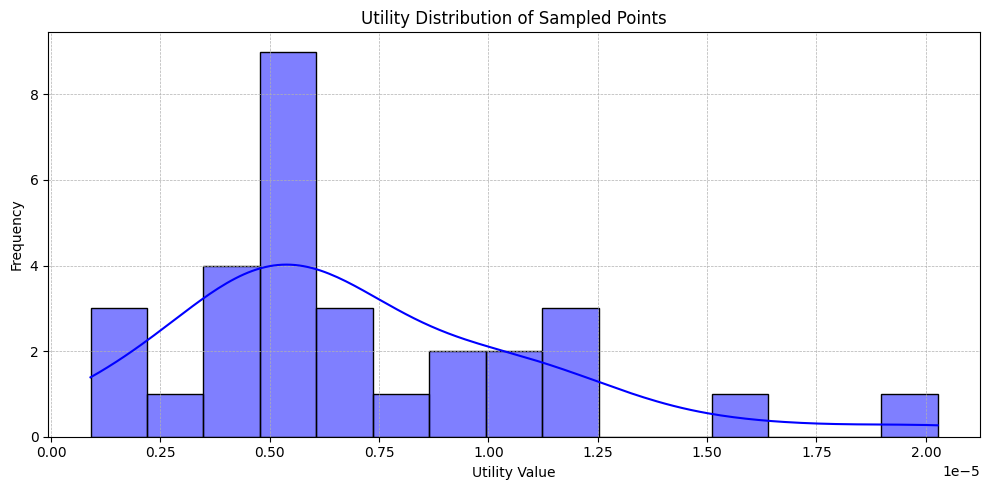

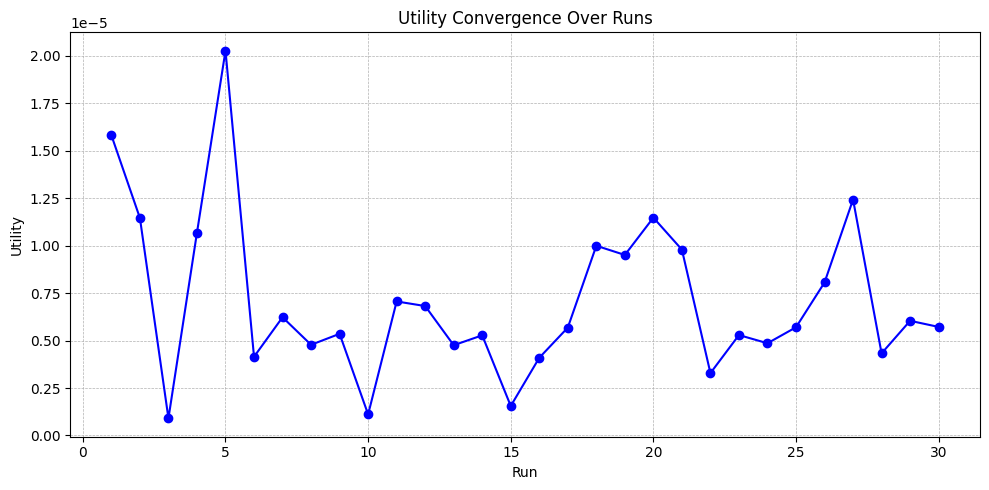

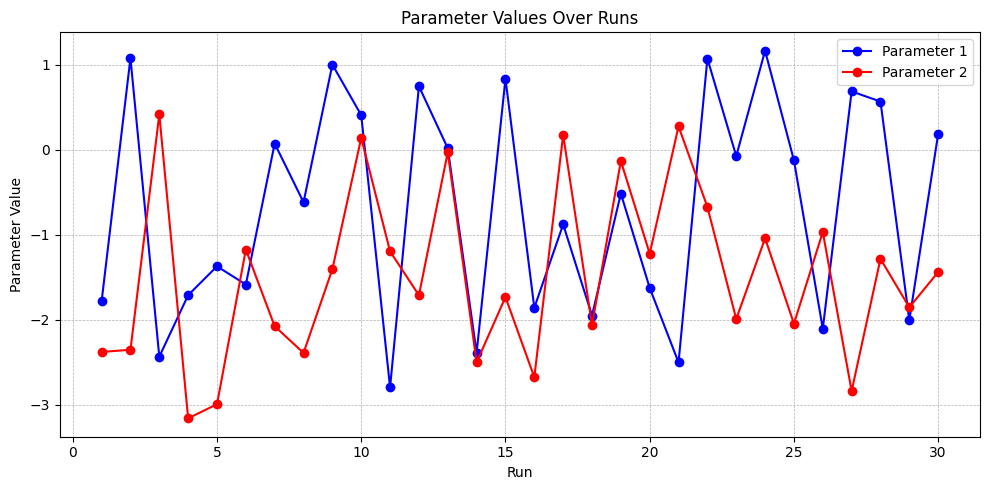

---------------------------------------------Optimize acquisition utility - Done --------------------------------------------------
fn_perform_simulation
fn_simulation
fn_simulation_config
fn_simulation_call
fn_process_activities
fn_output_od_balance
Travel Time NRMSE:  0.8413809230476286
Total Trips NRMSE:  0.7785700477220551
OD Matrix NRMSE:  0.8431719186232697
Averaged NRMSE:  0.8210409631309843
fn_update_value_pools
BEFORE ERROR:
 {'settings': {'LIBRARIES': ['bolfi_v3', 'preday'], 'SURROGATE_MODEL_STR': 'rf', 'UTILITY_FUNC_STR': 'ei', 'CHANGE_SHARE_ATTRIBUTES': 1.0, 'VARIATION_SD': 0.5, 'OBJECT_STORAGE_PATH': 'output/preday/city_tallinn_test_run', 'INITIAL_PARAMS_PATH': '/home/s212597/BOcalibration/parameters_manual.csv', 'OBSERVED_STATS_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallin_od_weighted_coded.csv', 'WEIGHT_MAP_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallinn_od_mask_coded.csv', 'DISTRICT_MAP_PATH': '/home/s212597/BOcalibration/T

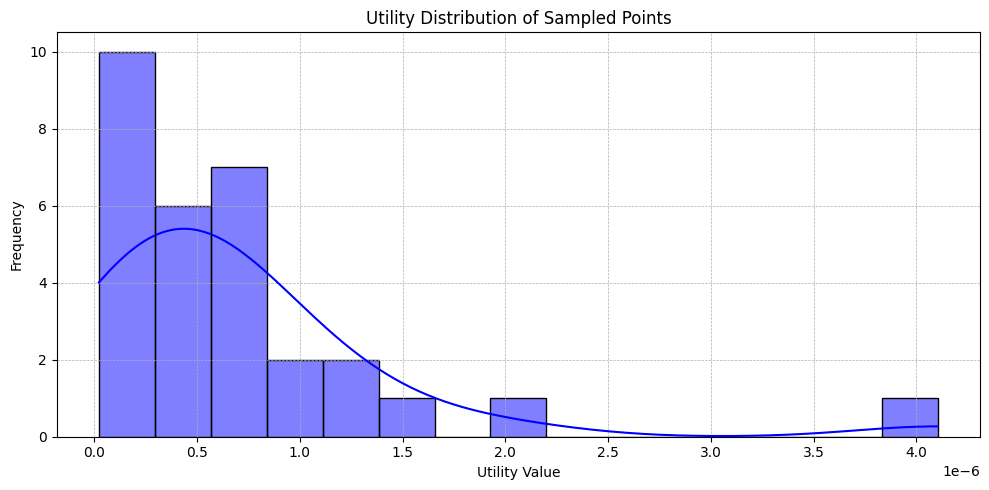

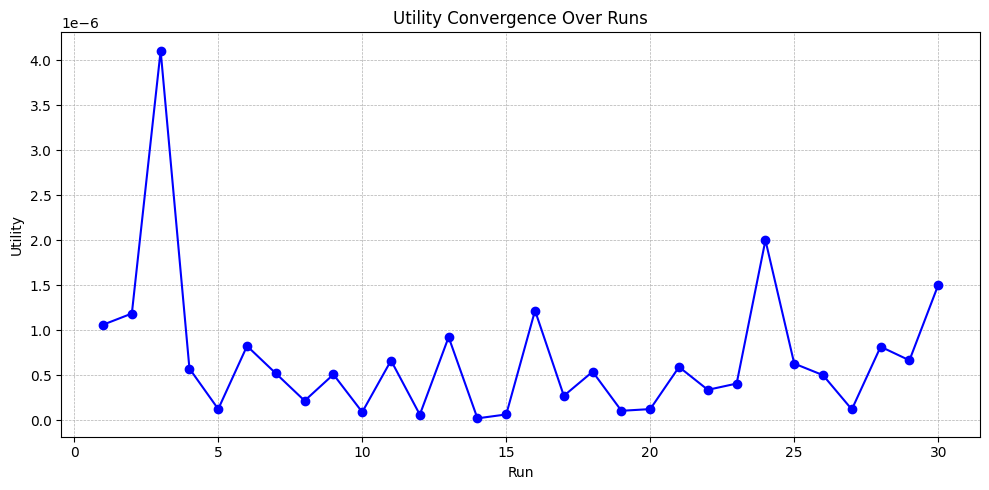

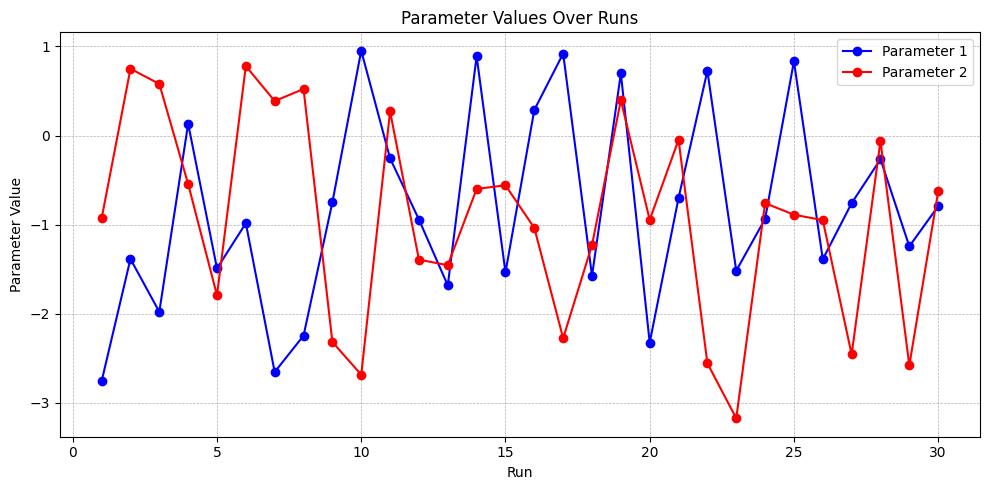

---------------------------------------------Optimize acquisition utility - Done --------------------------------------------------
fn_perform_simulation
fn_simulation
fn_simulation_config
fn_simulation_call
fn_process_activities
fn_output_od_balance
Travel Time NRMSE:  0.8371657068615922
Total Trips NRMSE:  0.7689986134184161
OD Matrix NRMSE:  0.8311002284432732
Averaged NRMSE:  0.8124215162410937
fn_update_value_pools
BEFORE ERROR:
 {'settings': {'LIBRARIES': ['bolfi_v3', 'preday'], 'SURROGATE_MODEL_STR': 'rf', 'UTILITY_FUNC_STR': 'ei', 'CHANGE_SHARE_ATTRIBUTES': 1.0, 'VARIATION_SD': 0.5, 'OBJECT_STORAGE_PATH': 'output/preday/city_tallinn_test_run', 'INITIAL_PARAMS_PATH': '/home/s212597/BOcalibration/parameters_manual.csv', 'OBSERVED_STATS_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallin_od_weighted_coded.csv', 'WEIGHT_MAP_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallinn_od_mask_coded.csv', 'DISTRICT_MAP_PATH': '/home/s212597/BOcalibration/T

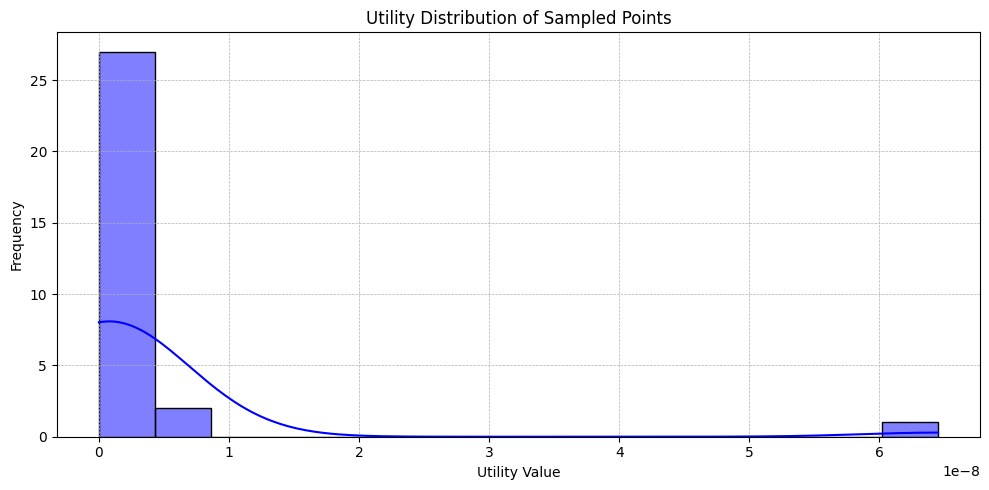

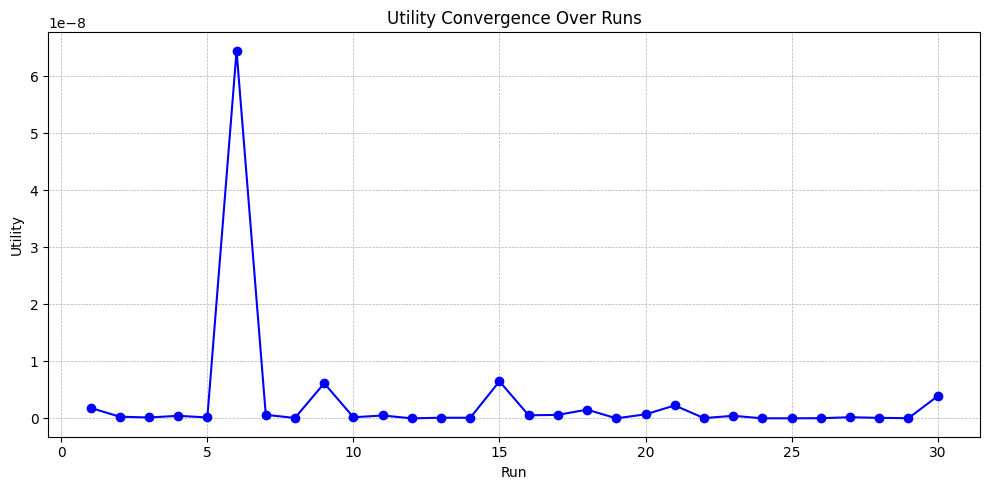

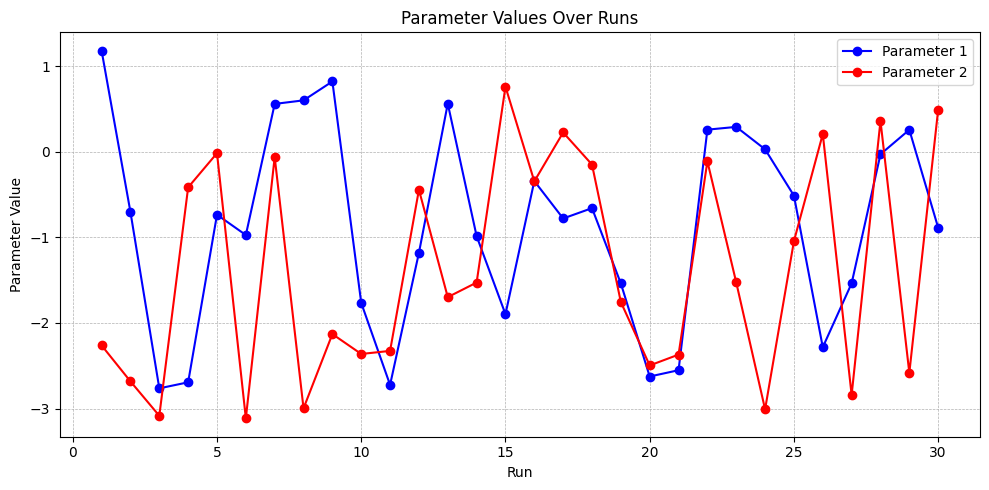

---------------------------------------------Optimize acquisition utility - Done --------------------------------------------------
fn_perform_simulation
fn_simulation
fn_simulation_config
fn_simulation_call
fn_process_activities
fn_output_od_balance
Travel Time NRMSE:  0.8400189569672107
Total Trips NRMSE:  0.7747773624113651
OD Matrix NRMSE:  0.828872093099284
Averaged NRMSE:  0.8145561374926199
fn_update_value_pools
BEFORE ERROR:
 {'settings': {'LIBRARIES': ['bolfi_v3', 'preday'], 'SURROGATE_MODEL_STR': 'rf', 'UTILITY_FUNC_STR': 'ei', 'CHANGE_SHARE_ATTRIBUTES': 1.0, 'VARIATION_SD': 0.5, 'OBJECT_STORAGE_PATH': 'output/preday/city_tallinn_test_run', 'INITIAL_PARAMS_PATH': '/home/s212597/BOcalibration/parameters_manual.csv', 'OBSERVED_STATS_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallin_od_weighted_coded.csv', 'WEIGHT_MAP_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallinn_od_mask_coded.csv', 'DISTRICT_MAP_PATH': '/home/s212597/BOcalibration/Ta

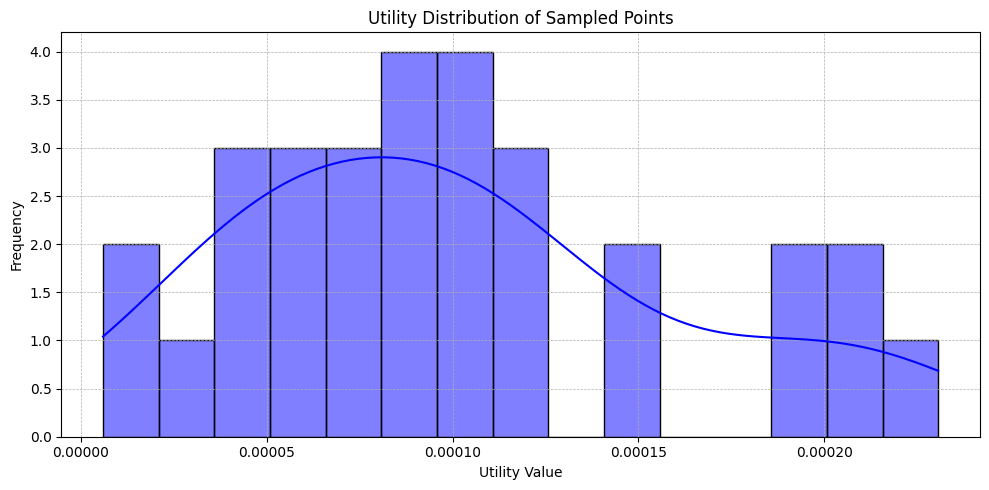

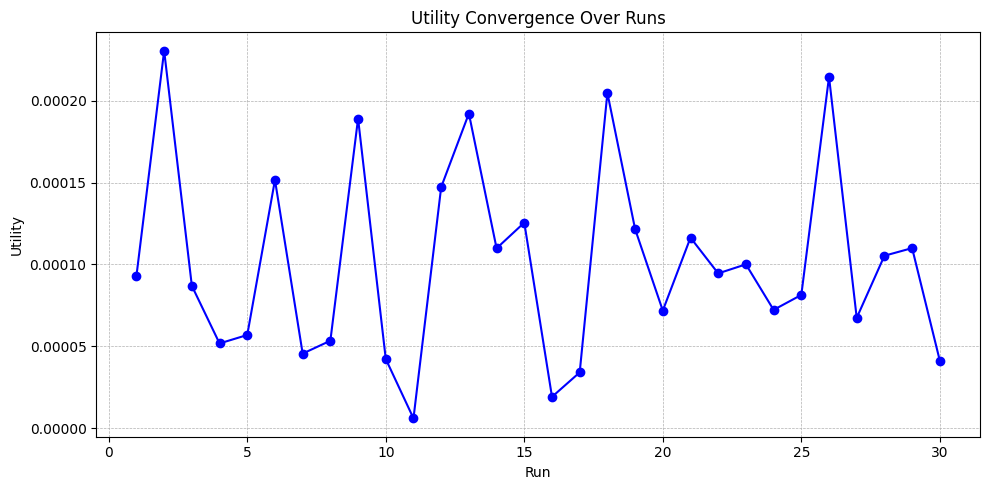

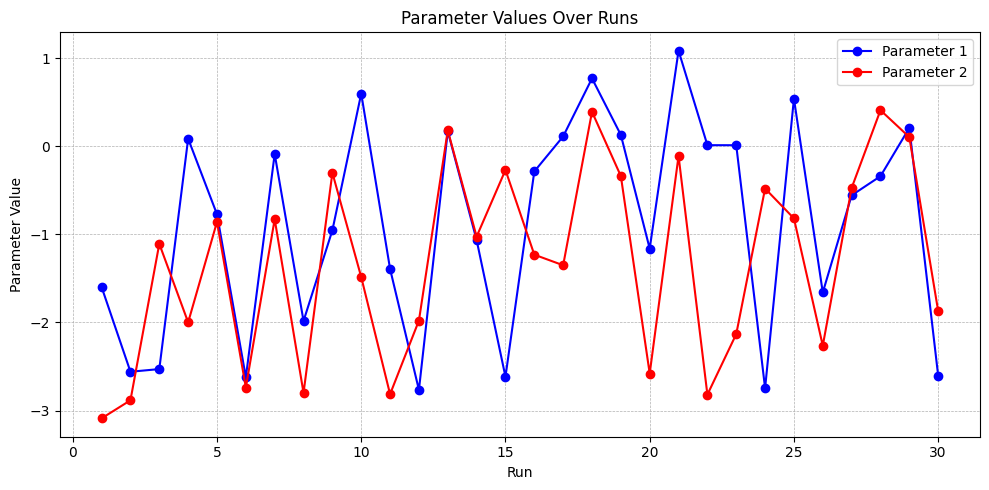

---------------------------------------------Optimize acquisition utility - Done --------------------------------------------------
fn_perform_simulation
fn_simulation
fn_simulation_config
fn_simulation_call
fn_process_activities
fn_output_od_balance
Travel Time NRMSE:  0.8404037366663507
Total Trips NRMSE:  0.7751637950881762
OD Matrix NRMSE:  0.8378726202717789
Averaged NRMSE:  0.8178133840087687
fn_update_value_pools
BEFORE ERROR:
 {'settings': {'LIBRARIES': ['bolfi_v3', 'preday'], 'SURROGATE_MODEL_STR': 'rf', 'UTILITY_FUNC_STR': 'ei', 'CHANGE_SHARE_ATTRIBUTES': 1.0, 'VARIATION_SD': 0.5, 'OBJECT_STORAGE_PATH': 'output/preday/city_tallinn_test_run', 'INITIAL_PARAMS_PATH': '/home/s212597/BOcalibration/parameters_manual.csv', 'OBSERVED_STATS_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallin_od_weighted_coded.csv', 'WEIGHT_MAP_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallinn_od_mask_coded.csv', 'DISTRICT_MAP_PATH': '/home/s212597/BOcalibration/T

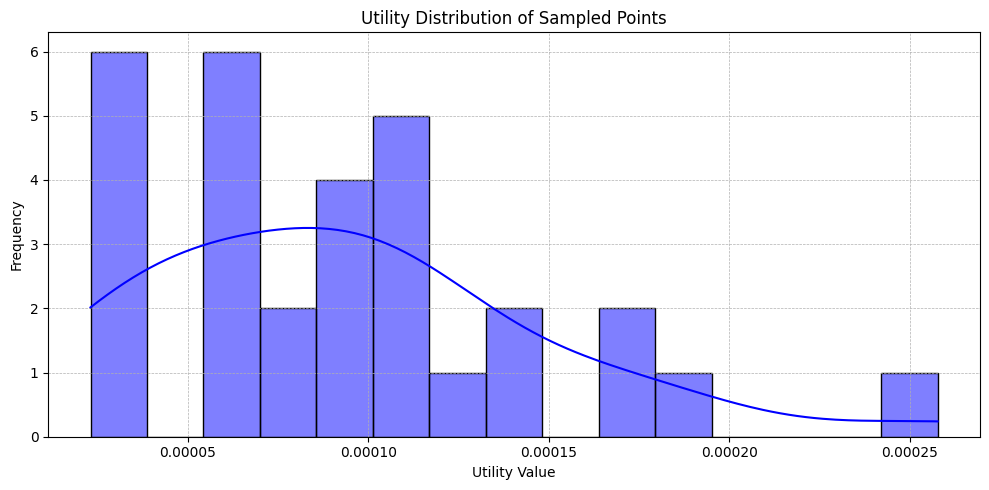

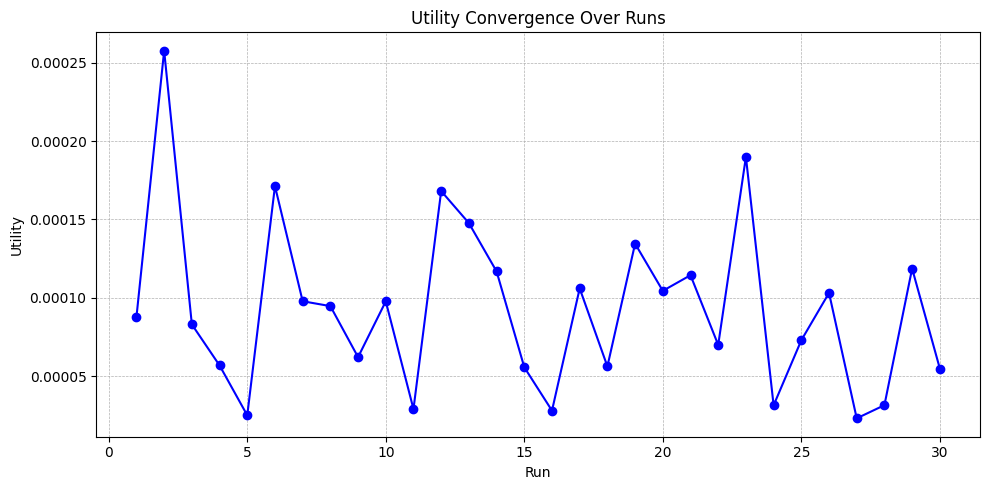

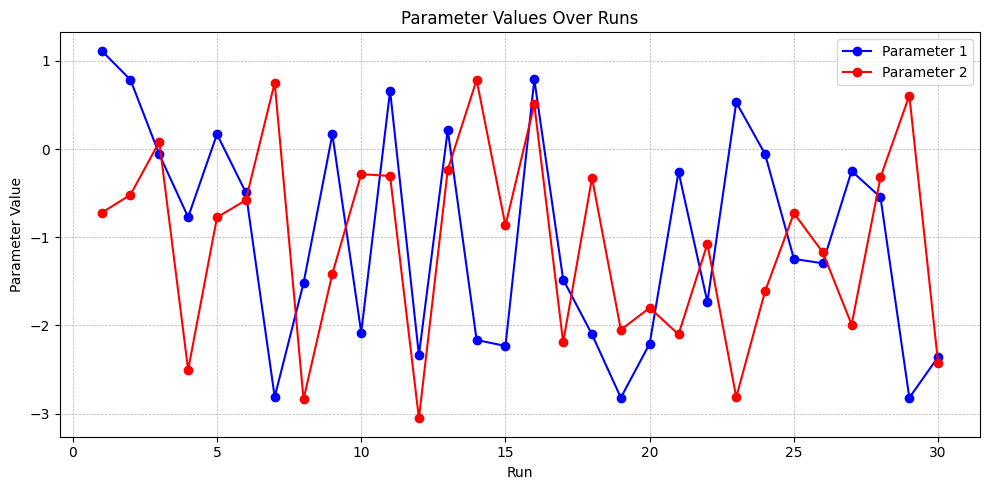

---------------------------------------------Optimize acquisition utility - Done --------------------------------------------------
fn_perform_simulation
fn_simulation
fn_simulation_config
fn_simulation_call
fn_process_activities
fn_output_od_balance
Travel Time NRMSE:  0.8466597275060784
Total Trips NRMSE:  0.7813279529034088
OD Matrix NRMSE:  0.8583868352500977
Averaged NRMSE:  0.8287915052198616
fn_update_value_pools
BEFORE ERROR:
 {'settings': {'LIBRARIES': ['bolfi_v3', 'preday'], 'SURROGATE_MODEL_STR': 'rf', 'UTILITY_FUNC_STR': 'ei', 'CHANGE_SHARE_ATTRIBUTES': 1.0, 'VARIATION_SD': 0.5, 'OBJECT_STORAGE_PATH': 'output/preday/city_tallinn_test_run', 'INITIAL_PARAMS_PATH': '/home/s212597/BOcalibration/parameters_manual.csv', 'OBSERVED_STATS_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallin_od_weighted_coded.csv', 'WEIGHT_MAP_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallinn_od_mask_coded.csv', 'DISTRICT_MAP_PATH': '/home/s212597/BOcalibration/T

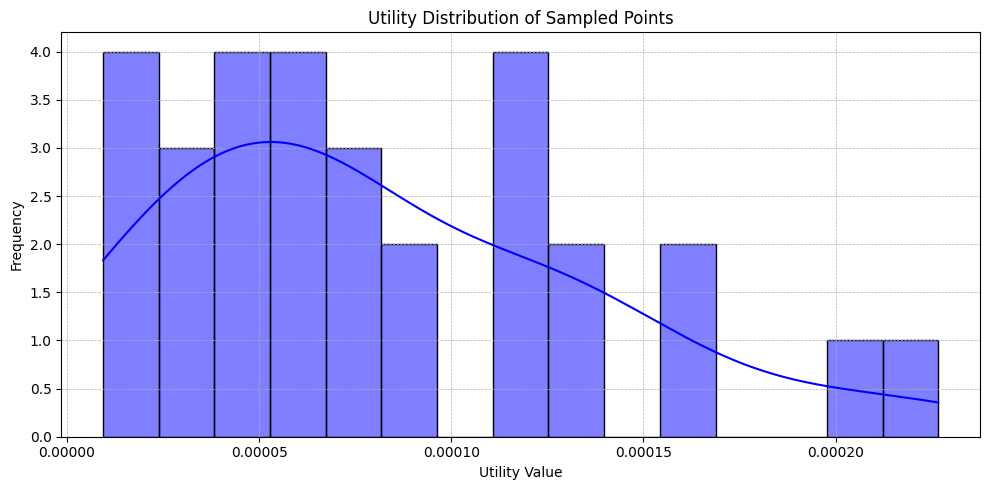

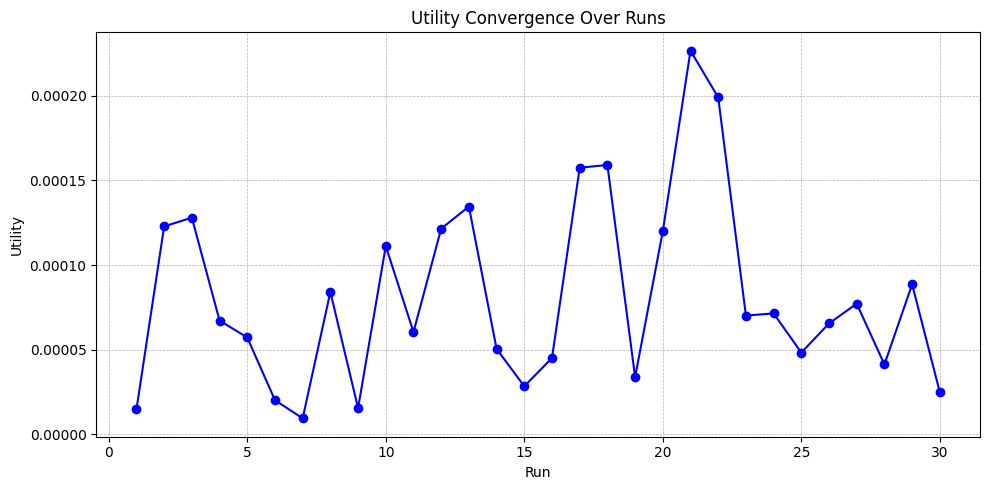

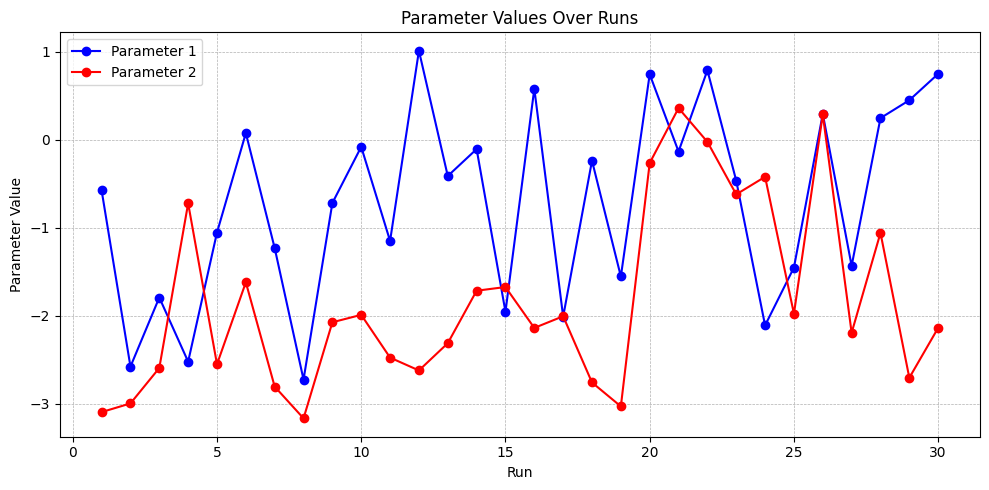

---------------------------------------------Optimize acquisition utility - Done --------------------------------------------------
fn_perform_simulation
fn_simulation
fn_simulation_config
fn_simulation_call
fn_process_activities
fn_output_od_balance
Travel Time NRMSE:  0.8396562433916193
Total Trips NRMSE:  0.773836384464538
OD Matrix NRMSE:  0.8387077234229394
Averaged NRMSE:  0.8174001170930322
fn_update_value_pools
BEFORE ERROR:
 {'settings': {'LIBRARIES': ['bolfi_v3', 'preday'], 'SURROGATE_MODEL_STR': 'rf', 'UTILITY_FUNC_STR': 'ei', 'CHANGE_SHARE_ATTRIBUTES': 1.0, 'VARIATION_SD': 0.5, 'OBJECT_STORAGE_PATH': 'output/preday/city_tallinn_test_run', 'INITIAL_PARAMS_PATH': '/home/s212597/BOcalibration/parameters_manual.csv', 'OBSERVED_STATS_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallin_od_weighted_coded.csv', 'WEIGHT_MAP_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallinn_od_mask_coded.csv', 'DISTRICT_MAP_PATH': '/home/s212597/BOcalibration/Ta

In [208]:
#Perform optimization
iteration_no=0
iteration_space = {}
visuals=[]

while not termination_fn(iteration=iteration_no, space=param_space,max_iterations=5): #*termination_args):
    print("-------------------- Iteration Number ----------------------------",iteration_no)
    # 1. get the best performer and save its parameters
    simulation_fn_params = fn_resolve_fn_params(selection_fn, _omit=["space", "selection_fn", "target"])    #   **locals())
    simulation_fn_params.pop('space', None)

    print("simulation fn params ",simulation_fn_params)
    iteration_space['optimal'] = fn_pull_optimal_samples(space=param_space['space'], selection_fn=selection_fn, target=target, **simulation_fn_params)
    #print("---------------------iteration_space[optimal]-------------------",iteration_space['optimal'])

    if verbose_output_fn is not None:
        verbose_output_fn("Retrieved current most optimal sample.", count=len(iteration_space['optimal']['space']))
    
    print('--------------------------------------------- Get the best performer - Done --------------------------------------------------')

    # 2. fit surrogate model
    if (iteration_no == 1) or (iteration_no % settings_obj['RETRAIN_AFTER'] == 0):
        fn_fit_params = fn_resolve_fn_params(fn_fit, omit=["type", "ds", "target", "param_def"])
        surrogate_fit_fn_params = fn_resolve_fn_params(surrogate_fit_fn, omit=["type", "ds", "target", "param_def", "method_params"])

        # Ensure 'type_fn' is not in the dictionaries
        if 'type_fn' in fn_fit_params:
            del fn_fit_params['type_fn']
        if 'type_fn' in surrogate_fit_fn_params:
            del surrogate_fit_fn_params['type_fn']

        iteration_space.setdefault('surrogate', {})
        iteration_space['surrogate']['model'] = fn_fit(surrogate_fit_fn, ds=param_space['space'], target=target, param_def=param_space['definition'], **fn_fit_params, **surrogate_fit_fn_params)
        param_space['surrogate'] = iteration_space['surrogate']

        if verbose_output_fn is not None:
            verbose_output_fn("Fitted surrogate model(s).", training_set_size=len(param_space['space']))
    else:
        iteration_space['surrogate'] = param_space['surrogate']
        if verbose_output_fn is not None:
            verbose_output_fn("Loaded previously trained surrogate model(s).", training_set_size=len(param_space['space']))
    print('---------------------------------------------Fit surrogate model - Done --------------------------------------------------')
    # 3. optimise acquisition utility

    # Fixing the structure 
    #new_data = []
    #for item in param_space['surrogate']['model']:
    #    new_data.append({
    #        'model': item['model']['model'],
    #        'sub_ds_idx': item['sub_ds_idx']
    #    })

    # Fixing the structure 
    new_data = []
    # Changed the below line with the below block:    
    #param_space['surrogate']=new_data
    # Check if 'surrogate' is a list in the dictionary
    if 'surrogate' in param_space and isinstance(param_space['surrogate'], list):
        for surrogate_item in param_space['surrogate']:
            model_item = surrogate_item.get('model', {})  # Use get() to handle the case when 'model' is not present
            new_data.append({
                'model': model_item.get('model', None),  # Replace with the actual key for the model
                'sub_ds_idx': surrogate_item.get('sub_ds_idx', None)  # Replace with the actual key for sub_ds_idx
            })

        # Update the value associated with the key 'surrogate'
        param_space['surrogate'] = new_data
    else:
        print("'surrogate' not found or is not a list in param_space.")

    # Resolve function parameters for acquisition function
    acquisition_fn_params = fn_resolve_fn_params(
        acquisition_fn, 
        omit=['type','param_space'],  #,target],  #    "sample_size " ,target], 
        iter_space=iteration_space, 
        sample_size=sample_size, 
        sampling_fn=sampling_fn, 
        surrogate_predict_fn=surrogate_predict_fn, 
        surrogate_utility_fn=surrogate_utility_fn, 
        inner_optimisation_fn=inner_optimisation_fn, 
        
    )

    # Resolve function parameters for inner optimisation function
    inner_optimisation_fn_params = fn_resolve_fn_params(
        inner_optimisation_fn, 
        omit=['sampling_fn','surrogate_predict_fn', 'surrogate_model', 'surrogate_utility_fn', 'iteration_space', 'param_range','param_space','sample_size',"omit"] 
        #target=target, 
        
    )

    # Remove 'kwargs' from the dictionaries
    acquisition_fn_params.pop('kwargs', None)
    inner_optimisation_fn_params.pop('kwargs', None)

    # Function call
    iteration_space['potential'] = fn_acquisition(
        type=acquisition_fn, 
        param_space=param_space, 
        **acquisition_fn_params,
        **inner_optimisation_fn_params
    )

    #print("FROM BO SCRIPT iteration_space['potential']:\n", iteration_space['potential'])

    visualization_data=iteration_space['potential'].copy()
    print('---------------------------------------------Optimize acquisition utility - Done --------------------------------------------------')
    #print("PARAM SPACE BEFORE POP\nparam_space: \n", param_space)
    if iteration_no == 1:
        #param_space['residual_pool'] = {key: param_space.pop(key) for key in ['time', 'trips', 'od']}
        iteration_space['surrogate'] = iteration_space['surrogate']['model'][0]['model']
    #print("PARAM SPACE AFTER POP\nparam_space: \n", param_space)

    # 4. simulate results of the picked-up instances

    # Get additional parameters for simulation_fn
    # Convert the values to a DataFrame
    df12 = pd.DataFrame([iteration_space["potential"]["space"][0]])
    # Rename columns using column names from param_space excluding the last one
    df12.columns = param_space["space"].columns[:-1]
    simulation_outcome =df12.apply(lambda row: simulation_fn(row, **simulation_fn_params_copy), axis=1)

    # Combine the existing data in iteration_space['potential']['space'] with the new simulation_outcome
    iteration_space['potential']['space'] = np.column_stack((iteration_space['potential']['space'], simulation_outcome))

    # Add a new column name to the dataframe
    iteration_space['potential']['space'] = pd.DataFrame(iteration_space['potential']['space'])
    iteration_space['potential']['space'].columns = list(iteration_space['potential']['space'].columns[:-1]) + [target]
    iteration_space['potential']['space'].columns = iteration_space["optimal"]["space"].columns

    # Call the verbose_output_fn if it exists
    if verbose_output_fn is not None:
        verbose_output_fn("Simulation of the most promising samples is completed.")

    print('---------------------------------------------Simulate results of the optimal sample set - Done --------------------------------------------------')

    # 5. add simulated results to the base set
    param_space['space'] = pd.concat([param_space['space'], pd.DataFrame(iteration_space['potential']['space'])], ignore_index=True)
    #print("-----------------------------param_space final--------------------------------------------------",param_space["space"])
    if verbose_output_fn is not None: 
        verbose_output_fn("Simulated results are added to the global set.")
        
    #print("SHARED ENV BEFORE IF\nshared_env: \n", shared_env)

    # Store NRMSEs at each iteration and append
    if iteration_no == 0:
        respool_dict = {}
        respool_dict = shared_env['param_space']['residual_pool']
        respool_dict['time'] = respool_dict['time'].tolist()
        respool_dict['trips'] = respool_dict['trips'].tolist()
        respool_dict['od'] = respool_dict['od'].tolist()

        print("FIRST: respool_dict: \n", respool_dict)
    else:
        respool_dict['time'] = respool_dict['time'].tolist()
        respool_dict['trips'] = respool_dict['trips'].tolist()
        respool_dict['od'] = respool_dict['od'].tolist()
        #print("LIST OR ARRAY?\n", type(respool_dict['time']))
        #print("LIST OR ARRAY? 2222222\n", type(shared_env['param_space']['residual_pool']['time'][-1]))
        respool_dict['time'].append(shared_env['param_space']['residual_pool']['time'][-1])
        respool_dict['trips'].append(shared_env['param_space']['residual_pool']['trips'][-1])
        respool_dict['od'].append(shared_env['param_space']['residual_pool']['od'][-1])
        #print("OTHER: respool_dict: \n", respool_dict)

    # Store required objects
    if save_object_fn is not None and store_iteratively: 
        print(type(settings))
        save_object_fn(iteration_space, settings, "param_space", stage = "optimisation", iteration = iteration_no)
    if save_object_fn is not None: 
        save_object_fn(param_space, settings,"output_object", stage = "partial")
    if "shared_env" in globals() and "param_space" in shared_env: 
        temp_respool = shared_env['param_space']['residual_pool']
        #print("TEMPRESPOOL!!!!!!!!!!!!!!!!", temp_respool)
        shared_env['param_space'] = param_space
        shared_env['param_space']['residual_pool'] = temp_respool
    
    #print("SHARED ENV AFTER IF\nshared_env: \n", shared_env)

    print('---------------------------------------------Add simulated results to the parameter space - Done --------------------------------------------------')

    # Increase iteration number
    iteration_no += 1
    visuals.append(visualization_data)
    for row in param_space["space"]["inadequacy"]:
        if row < 0.05:
            print("Row causing termination:", row)
            break

In [214]:
#It creates the dump file that includes the final param space
with open('param_space_dpb.pkl', 'wb') as f:
    pickle.dump(param_space, f)

#It creates the dump file that includes all the utility values for visualizations purposes
with open('visuals_dpb.pkl', 'wb') as f:
    pickle.dump(visuals, f)


In [210]:
# Calculate initial sample set's inadecuacy

initial = param_space["definition"].set_index("parameter")["value"].transpose().to_frame().T
initial.reset_index(drop=True, inplace=True)


original_outcome = initial.apply(lambda row: simulation_fn(row, **simulation_fn_params_copy), axis=1)
initial['inadequacy']=original_outcome


fn_perform_simulation
fn_simulation
fn_simulation_config
fn_simulation_call


fn_process_activities
fn_output_od_balance
Travel Time NRMSE:  0.8463979146775534
Total Trips NRMSE:  0.780072484344419
OD Matrix NRMSE:  0.8236347362703643
Averaged NRMSE:  0.8167017117641122
fn_update_value_pools
BEFORE ERROR:
 {'settings': {'LIBRARIES': ['bolfi_v3', 'preday'], 'SURROGATE_MODEL_STR': 'rf', 'UTILITY_FUNC_STR': 'ei', 'CHANGE_SHARE_ATTRIBUTES': 1.0, 'VARIATION_SD': 0.5, 'OBJECT_STORAGE_PATH': 'output/preday/city_tallinn_test_run', 'INITIAL_PARAMS_PATH': '/home/s212597/BOcalibration/parameters_manual.csv', 'OBSERVED_STATS_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallin_od_weighted_coded.csv', 'WEIGHT_MAP_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallinn_od_mask_coded.csv', 'DISTRICT_MAP_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallinn_grid_def.csv', 'MODE_BALANCE_PATH': '/home/s212597/BOcalibration/Tallinn_Python/data_preday/tallinn_mode_balance.csv', 'WORKERS_POPULATION_PATH': '/home/s212597/BOcalibration/

In [211]:
# Top 5 performers
optimal_samples5 = param_space["space"].nsmallest(5, 'inadequacy')
optimal_samples5

,dpb_beta_homemaker,dpb_beta_retired,dpb_beta_fulltime,dpb_beta_parttime,dpb_beta_selfemployed,dpb_beta_unemployed,itd_beta_ARR_1_8,itd_beta_ARR_1_7,itd_beta_ARR_1_6,itd_beta_ARR_1_5,...,ttde_beta_DEP_2_2,ttde_beta_DEP_2_3,ttde_beta_DEP_2_1,ttde_beta_DEP_2_6,ttde_beta_DEP_1_4,ttde_beta_DEP_1_6,ttde_beta_DEP_1_1,ttde_beta_DEP_1_3,ttde_beta_DEP_1_2,inadequacy
12,-1.980139,0.579933,4.281890,5.253090,0.531048,0.073297,1.181429,1.066006,1.208567,-3.609519,...,-0.011395,1.681994,1.130840,2.044114,13.238981,-0.735913,-9.572528,-0.422653,3.030734,0.812422
13,-0.973120,-3.114052,1.860068,2.760864,0.945734,-0.153520,-1.117282,1.666922,3.221021,-2.375992,...,-1.294776,0.884909,0.293555,1.786570,10.598585,-1.483870,-9.767702,1.784122,6.670145,0.814556
6,11.791375,0.337929,0.529825,1.550921,-16.453824,0.176287,-3.193369,-1.844315,-2.554861,-1.511408,...,0.991405,-1.353318,-1.763591,1.694361,-0.415457,-26.874175,4.907113,-5.006514,-1.118648,0.815300
7,11.671954,-2.556985,1.079187,-0.959991,-17.637473,-0.239430,-0.234013,-0.782609,-2.518394,0.354964,...,0.438942,-1.727623,-0.017441,1.078680,0.006762,-27.316737,4.768707,-1.963608,-0.808089,0.815314
1,13.266669,-2.581058,1.875696,1.339917,-17.760879,1.425608,-1.732321,-0.273732,0.246386,0.308201,...,-0.324687,0.141816,-2.219115,4.685454,-0.642289,-27.479853,2.581779,-3.913792,0.441825,0.815891


In [213]:
param_space

{'space':     dpb_beta_homemaker  dpb_beta_retired  dpb_beta_fulltime  \
 0            -0.820440         -1.212404           3.497458   
 1            13.266669         -2.581058           1.875696   
 2            11.992346          0.168434           1.058550   
 3            13.155452         -0.215913           0.745022   
 4            13.521811          0.142104          -0.999773   
 5            12.255718         -0.171161          -1.492335   
 6            11.791375          0.337929           0.529825   
 7            11.671954         -2.556985           1.079187   
 8            13.232824         -2.065001           2.127341   
 9            11.048112          0.668798           1.374937   
 10           12.544182         -1.684919           1.986693   
 11           -1.371542         -2.992502           5.066460   
 12           -1.980139          0.579933           4.281890   
 13           -0.973120         -3.114052           1.860068   
 14           -2.559804        